# Homework №1

    In this homework you will need to implement the following stuff:
        1) Discrete Fourier Transform
        2) Fast Fourier Transform
        3) Compare by performance
        4) Short-time Fourier Transform based on (2) and hann window function
        5) MelScale
        6) Digit classification based on you melspectrograms
        
    Note:
        You should test your implementation with torchaudio functions
        (e.g. torch.allclose(torchaudio.transforms.Spectrogram.__call__, your_function))

### Main rules
    1) All operations must be implemented with pytorch (don't use numpy)
    2) Everything should support batch input
    3) No cycles, only matrix multiplications
    4) Clean and clear code 

In [2]:
import torch
import torchaudio
import os

# Discrete Fourier Transform (1 pts)

In [3]:
wav_file = 'audio.wav'
wav, sr = torchaudio.load(wav_file)
wav = wav[:, : 1024]
print(sr)

22050


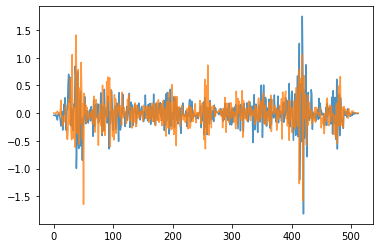

In [4]:
import numpy as np
import matplotlib.pylab as plt


def dft(wav, is_one):
    wav = wav.squeeze().type(torch.cfloat)
    n = wav.shape[0]
    if is_one:
        m = n // 2 + 1
    else:
        m = n
    i = torch.arange(n).expand((m, n))
    j = torch.arange(m).reshape(-1, 1).expand((m, n))
    M = torch.exp((-2 * 1j * np.pi * ((i * j) % n)) / n)
    transformed = torch.view_as_real(torch.mv(M, wav)).unsqueeze(0)
    return transformed


plt.plot(dft(wav, True).squeeze(), alpha=0.8)
plt.show()

### Sanity Check

In [6]:
wav = wav[:, : 1024]

torch.allclose(
    torch.rfft(wav, signal_ndim=1),
    dft(wav, True),
    atol=0.001
)

True

# Fast Fourier Transform (3pts)

    A common task for machine learning engineer is to take an paper and implement it.
    So, just do it!
[Tap on me](http://www.robots.ox.ac.uk/~sjrob/Teaching/SP/l7.pdf)
    

In [20]:
import torch.nn.functional as F
import math


def fft_simple(f, n):
    n_old = n
    even = torch.arange(0, n, 2)
    odd = torch.arange(1, n, 2)
    n //= 2
    mult = torch.arange(n)
    if n == 1:
        g = torch.cat((f[0], f[0]))
        h = torch.cat((f[1], f[1]))
        w = torch.exp(torch.tensor([0, -1j * np.pi]))
        return g + w * h

    g = fft_simple(f[even], n)
    h = fft_simple(f[odd], n)
    w = torch.exp(torch.tensor([-1j * 2 * np.pi / n_old]) * mult)
    return torch.cat((g, g)) + torch.cat((w, -w)) * torch.cat((h, h))


def fft_cycle(f, n):
    f = f.reshape(-1)
    width = n // 2
    height = 2
    dft_2 = torch.exp(torch.tensor([[0, -1j * np.pi]])).reshape(-1)
    lwr_lvl_pairs = torch.stack(
        [f[: width], f[width:]], dim=1).type(torch.cfloat)
    lwr_lvl_ft = torch.stack(
        [lwr_lvl_pairs.sum(dim=1), torch.mv(lwr_lvl_pairs, dft_2)])
    ft = lwr_lvl_ft
    while width > 1:
        mult = torch.arange(height)
        width //= 2
        height *= 2
        g = ft[:, : width]
        h = ft[:, width:]
        w = torch.exp(torch.tensor([-1j * 2 * np.pi / height]) * mult).view(-1, 1).expand(height // 2, width)
        ft = torch.cat((g, g)) + torch.cat((w, -w)) * torch.cat((h, h))
    return ft.squeeze()


def fft(waw, is_one, fft_type=fft_cycle):
    waw = waw.view(-1,1)
    first_n = waw.shape[0]
    n = 2 ** math.ceil(math.log2(first_n))
    waw = F.pad(waw, (0, n - first_n), 'constant', 0).view(-1, 1)
    transformed = torch.view_as_real(fft_type(waw, n))
    if is_one:
        transformed = transformed[: first_n // 2 + 1]
    transformed = transformed.unsqueeze(0)
    return transformed

# A comparison of the performance (1e-7 pts)
    Do pretty images :)

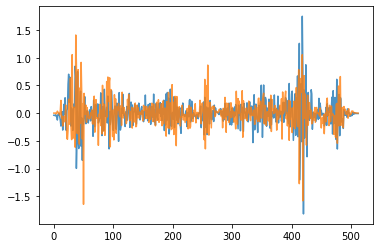

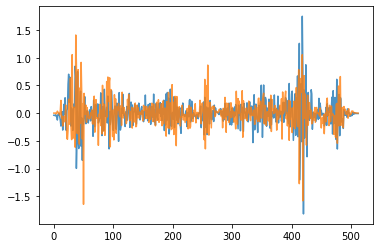

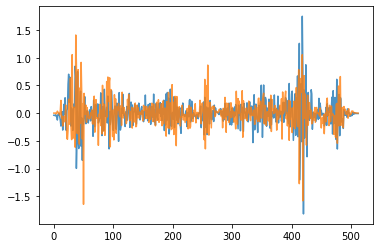

In [21]:
plt.plot(fft(wav, True, fft_simple).squeeze(), alpha=0.8);
plt.show()

plt.plot(fft(wav, True, fft_cycle).squeeze(), alpha=0.8)
plt.show()

plt.plot(torch.rfft(wav, signal_ndim=1).squeeze(), alpha=0.8)
plt.show()

In [22]:
%%timeit

dft(wav, True)

3.5 ms ± 16.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
%%timeit

fft(wav, True, fft_simple)

61.8 ms ± 200 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [24]:
%%timeit

fft(wav, True, fft_cycle)

763 µs ± 1.08 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Short-time Fourier Transform (2 pts)

    Use torch.hann_window

In [25]:
def stft(wav, center, stride, window_w):
    wav = wav.squeeze()
    window = torch.hann_window(window_w)
    transformed = torch.tensor([])
    n = wav.shape[0]

    if center:
        w = window_w // 2
        wav = F.pad(wav, (w, w), 'constant')
        shift = 0
    else:
        shift = window_w

    for i in range(0, n - shift + 1, stride):
        frame = wav[i: i + window_w] * window
        transformed = torch.cat([transformed, fft(frame, True)], dim=0)

    return transformed.transpose(1, 0).unsqueeze(0)

In [26]:
wav, sr = torchaudio.load(wav_file)
wav = wav[:, : 1024]

torch.allclose(
    torch.stft(wav, n_fft=256, hop_length=10, center=False, window=torch.hann_window(256), pad_mode='constant'),
    stft(wav, False, 10, 256),
    atol=0.001
)

/home/pfederov/DL/venv/lib/python3.6/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)


True

In [27]:
torch.allclose(
    torch.stft(wav, n_fft=256, hop_length=10, center=True, window=torch.hann_window(256), pad_mode='constant'),
    stft(wav, True, 10, 256),
    atol=0.001
)

True

In [28]:
wav, sr = torchaudio.load(wav_file)

torch.allclose(
    torch.stft(wav, n_fft=1024, hop_length=256, center=True, window=torch.hann_window(1024), pad_mode='constant'),
    stft(wav, True, 256, 1024),
    atol=0.001
)

True

# MelScale (2 pts)

[Tap on me](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/)

In [29]:
M = 2595
const = 700


def to_mel(points):
    return M * math.log10(1.0 + torch.true_divide(points, const))


class MelScale(torch.nn.Module):
    def __init__(self, n_mels=128, sample_rate=16000, f_min=300, f_max=None, n_stft=513):
        if not f_max:
            f_max = sample_rate // 2
        self.sample_rate = sample_rate
        self.fmin_mel = to_mel(torch.tensor([f_min]))
        self.fmax_mel = to_mel(torch.tensor([f_max]))
        self.n_stft = n_stft
        self.n_mels = n_mels
        self.init()

    def init(self):
        mel_points = torch.linspace(
            self.fmin_mel, self.fmax_mel, self.n_mels + 2)
        points = torch.floor(
            const * (10 ** (mel_points / M) - 1.0)).reshape(-1, 1)

        ar = torch.linspace(0, self.sample_rate // 2,
                            self.n_stft).expand(self.n_mels, self.n_stft)
        d = torch.max(torch.tensor(
            [1.0]), (points[1:] - points[: -1])).reshape(-1, 1)
        left = (ar - points[:-2]) * (ar >= points[:-2]) * \
            (ar <= points[1:-1]) / d[:-1]
        right = (points[2:] - ar) * (ar > points[1:-1]) * \
            (ar <= points[2:]) / d[1:]
        self.filters = right + left

    def forward(self, freqs):
        frames = freqs.shape[2]
        spectrogram = torch.norm(freqs, 2, -1).squeeze().transpose(0, 1)
        res = torch.matmul(self.filters, spectrogram.transpose(0, 1))
        return res

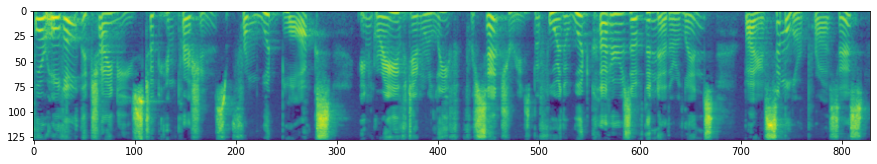

In [30]:
freqs = torch.stft(wav,
    n_fft=1024,
    hop_length=256,
    win_length=1024,
    window=torch.hann_window(1024),
    center=False
)

mel = MelScale(f_min=300, f_max=8000)
mel_res = mel.forward(freqs)
plt.figure(figsize=(15, 3))
plt.imshow(torch.log(mel_res))
plt.show()

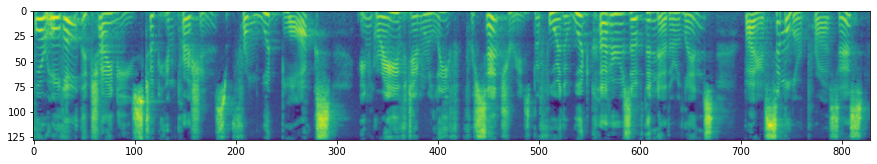

In [31]:
mel = torchaudio.transforms.MelScale(f_min=300, f_max=8000)
spectrogram = torch.norm(freqs, 2, -1)
mel_res = mel.forward(spectrogram)
plt.figure(figsize=(15, 3))
plt.imshow(torch.log(mel_res.squeeze()))
plt.show()

# Digit classification (5 pts)

    1) Download data from google drive: https://drive.google.com/file/d/1ouSOru91p-ZJCyI6E8cGh7N0r3vffi06/view?usp=sharing
    
    2) Split data in 80/20 proportion. Please note that both the train and the test
    must contain all types of digits and all speakers, so carefully split the data.
    
    3) The AudioMNIST dataset1 consists of 30000 audio recordings (9.5 hours) 
    of spoken digits (0-9) in English with 50 repetitions per digit for each of the 60 different speakers.
    
    4) Build a classificator of spoken digits. You can use any neural network architecture you like.
        The minimum required quality of classificator will be announced.
    
    5) Each wavfile has the following format: digit_speackerid_wavid.wav
        For example, 6_01_47.wav:
            6 -- the number 6 is spoken
            01 -- the number is spoken by 1 speaker
            47 -- id of wavfile        

    Bonus:
        If you implement a good model or use some augmentation (or something else),
        you can expect to obtain bonuses of up to 3 points.

In [96]:
# !unzip AudioMNIST.zip

Archive:  AudioMNIST.zip
   creating: AudioMNIST/
   creating: AudioMNIST/59/
   creating: AudioMNIST/50/
   creating: AudioMNIST/57/
   creating: AudioMNIST/03/
   creating: AudioMNIST/04/
   creating: AudioMNIST/32/
   creating: AudioMNIST/35/
   creating: AudioMNIST/56/
   creating: AudioMNIST/51/
   creating: AudioMNIST/58/
   creating: AudioMNIST/60/
   creating: AudioMNIST/34/
   creating: AudioMNIST/33/
   creating: AudioMNIST/05/
   creating: AudioMNIST/02/
  inflating: AudioMNIST/.DS_Store    
  inflating: __MACOSX/AudioMNIST/._.DS_Store  
  inflating: AudioMNIST/audioMNIST_meta.txt  
   creating: AudioMNIST/20/
   creating: AudioMNIST/18/
   creating: AudioMNIST/27/
   creating: AudioMNIST/11/
   creating: AudioMNIST/29/
   creating: AudioMNIST/16/
   creating: AudioMNIST/42/
   creating: AudioMNIST/45/
   creating: AudioMNIST/28/
   creating: AudioMNIST/17/
   creating: AudioMNIST/10/
   creating: AudioMNIST/19/
   creating: AudioMNIST/26/
   creating: AudioMNIST/21/
   crea

  inflating: AudioMNIST/59/8_59_28.wav  
  inflating: AudioMNIST/59/8_59_14.wav  
  inflating: AudioMNIST/59/5_59_17.wav  
  inflating: AudioMNIST/59/5_59_16.wav  
  inflating: AudioMNIST/59/8_59_15.wav  
  inflating: AudioMNIST/59/8_59_29.wav  
  inflating: AudioMNIST/59/6_59_36.wav  
  inflating: AudioMNIST/59/6_59_22.wav  
  inflating: AudioMNIST/59/1_59_46.wav  
  inflating: AudioMNIST/59/4_59_49.wav  
  inflating: AudioMNIST/59/3_59_11.wav  
  inflating: AudioMNIST/59/3_59_39.wav  
  inflating: AudioMNIST/59/7_59_41.wav  
  inflating: AudioMNIST/59/0_59_31.wav  
  inflating: AudioMNIST/59/0_59_25.wav  
  inflating: AudioMNIST/59/1_59_6.wav  
  inflating: AudioMNIST/59/0_59_6.wav  
  inflating: AudioMNIST/59/0_59_19.wav  
  inflating: AudioMNIST/59/0_59_21.wav  
  inflating: AudioMNIST/59/0_59_35.wav  
  inflating: AudioMNIST/59/0_59_2.wav  
  inflating: AudioMNIST/59/1_59_2.wav  
  inflating: AudioMNIST/59/7_59_45.wav  
  inflating: AudioMNIST/59/3_59_15.wav  
  inflating: AudioMN

  inflating: AudioMNIST/50/4_50_28.wav  
  inflating: AudioMNIST/50/1_50_33.wav  
  inflating: AudioMNIST/50/1_50_27.wav  
  inflating: AudioMNIST/50/6_50_43.wav  
  inflating: AudioMNIST/50/8_50_48.wav  
  inflating: AudioMNIST/50/2_50_13.wav  
  inflating: AudioMNIST/50/2_50_12.wav  
  inflating: AudioMNIST/50/8_50_49.wav  
  inflating: AudioMNIST/50/6_50_42.wav  
  inflating: AudioMNIST/50/1_50_26.wav  
  inflating: AudioMNIST/50/1_50_32.wav  
  inflating: AudioMNIST/50/4_50_29.wav  
  inflating: AudioMNIST/50/4_50_15.wav  
  inflating: AudioMNIST/50/9_50_16.wav  
  inflating: AudioMNIST/50/4_50_9.wav  
  inflating: AudioMNIST/50/5_50_9.wav  
  inflating: AudioMNIST/50/0_50_3.wav  
  inflating: AudioMNIST/50/7_50_21.wav  
  inflating: AudioMNIST/50/1_50_3.wav  
  inflating: AudioMNIST/50/7_50_35.wav  
  inflating: AudioMNIST/50/0_50_45.wav  
  inflating: AudioMNIST/50/0_50_36.wav  
  inflating: AudioMNIST/50/0_50_22.wav  
  inflating: AudioMNIST/50/7_50_46.wav  
  inflating: AudioMN

  inflating: AudioMNIST/50/0_50_49.wav  
  inflating: AudioMNIST/50/7_50_13.wav  
  inflating: AudioMNIST/50/9_50_30.wav  
  inflating: AudioMNIST/50/9_50_24.wav  
  inflating: AudioMNIST/50/5_50_7.wav  
  inflating: AudioMNIST/50/9_50_18.wav  
  inflating: AudioMNIST/50/4_50_7.wav  
  inflating: AudioMNIST/50/3_50_43.wav  
  inflating: AudioMNIST/50/4_50_33.wav  
  inflating: AudioMNIST/50/4_50_27.wav  
  inflating: AudioMNIST/50/1_50_14.wav  
  inflating: AudioMNIST/50/1_50_28.wav  
  inflating: AudioMNIST/50/2_50_34.wav  
  inflating: AudioMNIST/50/2_50_20.wav  
  inflating: AudioMNIST/50/8_50_47.wav  
  inflating: AudioMNIST/50/5_50_44.wav  
  inflating: AudioMNIST/50/5_50_45.wav  
  inflating: AudioMNIST/50/8_50_46.wav  
  inflating: AudioMNIST/50/2_50_21.wav  
  inflating: AudioMNIST/50/2_50_35.wav  
  inflating: AudioMNIST/50/1_50_29.wav  
  inflating: AudioMNIST/50/1_50_15.wav  
  inflating: AudioMNIST/50/4_50_26.wav  
  inflating: AudioMNIST/50/4_50_32.wav  
  inflating: Audio

  inflating: AudioMNIST/57/5_57_21.wav  
  inflating: AudioMNIST/57/5_57_20.wav  
  inflating: AudioMNIST/57/5_57_34.wav  
  inflating: AudioMNIST/57/8_57_23.wav  
  inflating: AudioMNIST/57/8_57_37.wav  
  inflating: AudioMNIST/57/2_57_44.wav  
  inflating: AudioMNIST/57/6_57_28.wav  
  inflating: AudioMNIST/57/6_57_14.wav  
  inflating: AudioMNIST/57/4_57_43.wav  
  inflating: AudioMNIST/57/3_57_27.wav  
  inflating: AudioMNIST/57/3_57_33.wav  
  inflating: AudioMNIST/57/9_57_40.wav  
  inflating: AudioMNIST/57/0_57_6.wav  
  inflating: AudioMNIST/57/1_57_6.wav  
  inflating: AudioMNIST/57/0_57_13.wav  
  inflating: AudioMNIST/57/0_57_22.wav  
  inflating: AudioMNIST/57/0_57_36.wav  
  inflating: AudioMNIST/57/7_57_46.wav  
  inflating: AudioMNIST/57/3_57_16.wav  
  inflating: AudioMNIST/57/4_57_1.wav  
  inflating: AudioMNIST/57/5_57_1.wav  
  inflating: AudioMNIST/57/1_57_41.wav  
  inflating: AudioMNIST/57/6_57_19.wav  
  inflating: AudioMNIST/57/6_57_25.wav  
  inflating: AudioMN

  inflating: AudioMNIST/03/0_03_33.wav  
  inflating: AudioMNIST/03/0_03_27.wav  
  inflating: AudioMNIST/03/8_03_3.wav  
  inflating: AudioMNIST/03/9_03_3.wav  
  inflating: AudioMNIST/03/7_03_43.wav  
  inflating: AudioMNIST/03/9_03_48.wav  
  inflating: AudioMNIST/03/3_03_13.wav  
  inflating: AudioMNIST/03/3_03_12.wav  
  inflating: AudioMNIST/03/9_03_49.wav  
  inflating: AudioMNIST/03/7_03_42.wav  
  inflating: AudioMNIST/03/9_03_2.wav  
  inflating: AudioMNIST/03/8_03_2.wav  
  inflating: AudioMNIST/03/0_03_26.wav  
  inflating: AudioMNIST/03/0_03_32.wav  
  inflating: AudioMNIST/03/5_03_29.wav  
  inflating: AudioMNIST/03/5_03_15.wav  
  inflating: AudioMNIST/03/8_03_16.wav  
  inflating: AudioMNIST/03/2_03_1.wav  
  inflating: AudioMNIST/03/3_03_1.wav  
  inflating: AudioMNIST/03/6_03_21.wav  
  inflating: AudioMNIST/03/6_03_35.wav  
  inflating: AudioMNIST/03/1_03_45.wav  
  inflating: AudioMNIST/03/1_03_47.wav  
  inflating: AudioMNIST/03/6_03_23.wav  
  inflating: AudioMNIS

  inflating: AudioMNIST/03/5_03_35.wav  
  inflating: AudioMNIST/03/0_03_12.wav  
  inflating: AudioMNIST/03/9_03_41.wav  
  inflating: AudioMNIST/03/3_03_26.wav  
  inflating: AudioMNIST/03/3_03_32.wav  
  inflating: AudioMNIST/03/4_03_42.wav  
  inflating: AudioMNIST/03/4_03_43.wav  
  inflating: AudioMNIST/03/3_03_33.wav  
  inflating: AudioMNIST/03/3_03_27.wav  
  inflating: AudioMNIST/03/9_03_40.wav  
  inflating: AudioMNIST/03/0_03_13.wav  
  inflating: AudioMNIST/03/5_03_34.wav  
  inflating: AudioMNIST/03/5_03_20.wav  
  inflating: AudioMNIST/03/3_03_8.wav  
  inflating: AudioMNIST/03/8_03_37.wav  
  inflating: AudioMNIST/03/8_03_23.wav  
  inflating: AudioMNIST/03/2_03_8.wav  
  inflating: AudioMNIST/03/2_03_44.wav  
  inflating: AudioMNIST/03/6_03_28.wav  
  inflating: AudioMNIST/03/7_03_2.wav  
  inflating: AudioMNIST/03/6_03_14.wav  
  inflating: AudioMNIST/03/6_03_2.wav  
  inflating: AudioMNIST/03/7_03_0.wav  
  inflating: AudioMNIST/03/6_03_0.wav  
  inflating: AudioMNIS

  inflating: AudioMNIST/04/2_04_35.wav  
  inflating: AudioMNIST/04/2_04_21.wav  
  inflating: AudioMNIST/04/7_04_8.wav  
  inflating: AudioMNIST/04/6_04_8.wav  
  inflating: AudioMNIST/04/1_04_29.wav  
  inflating: AudioMNIST/04/1_04_15.wav  
  inflating: AudioMNIST/04/1_04_17.wav  
  inflating: AudioMNIST/04/2_04_37.wav  
  inflating: AudioMNIST/04/2_04_23.wav  
  inflating: AudioMNIST/04/3_04_0.wav  
  inflating: AudioMNIST/04/8_04_44.wav  
  inflating: AudioMNIST/04/2_04_0.wav  
  inflating: AudioMNIST/04/5_04_47.wav  
  inflating: AudioMNIST/04/0_04_48.wav  
  inflating: AudioMNIST/04/7_04_38.wav  
  inflating: AudioMNIST/04/8_04_3.wav  
  inflating: AudioMNIST/04/7_04_10.wav  
  inflating: AudioMNIST/04/9_04_3.wav  
  inflating: AudioMNIST/04/9_04_33.wav  
  inflating: AudioMNIST/04/9_04_27.wav  
  inflating: AudioMNIST/04/3_04_40.wav  
  inflating: AudioMNIST/04/4_04_18.wav  
  inflating: AudioMNIST/04/4_04_30.wav  
  inflating: AudioMNIST/04/4_04_24.wav  
  inflating: AudioMNIS

  inflating: AudioMNIST/04/9_04_28.wav  
  inflating: AudioMNIST/04/9_04_14.wav  
  inflating: AudioMNIST/04/4_04_17.wav  
  inflating: AudioMNIST/04/4_04_16.wav  
  inflating: AudioMNIST/04/9_04_15.wav  
  inflating: AudioMNIST/04/9_04_29.wav  
  inflating: AudioMNIST/04/7_04_22.wav  
  inflating: AudioMNIST/04/7_04_36.wav  
  inflating: AudioMNIST/04/0_04_46.wav  
  inflating: AudioMNIST/04/5_04_49.wav  
  inflating: AudioMNIST/04/2_04_11.wav  
  inflating: AudioMNIST/04/2_04_39.wav  
  inflating: AudioMNIST/04/6_04_41.wav  
  inflating: AudioMNIST/04/6_04_4.wav  
  inflating: AudioMNIST/04/7_04_4.wav  
  inflating: AudioMNIST/04/1_04_25.wav  
  inflating: AudioMNIST/04/1_04_31.wav  
  inflating: AudioMNIST/04/1_04_19.wav  
  inflating: AudioMNIST/04/1_04_42.wav  
  inflating: AudioMNIST/04/6_04_32.wav  
  inflating: AudioMNIST/04/6_04_26.wav  
  inflating: AudioMNIST/04/8_04_39.wav  
  inflating: AudioMNIST/04/8_04_11.wav  
  inflating: AudioMNIST/04/1_04_6.wav  
  inflating: AudioM

  inflating: AudioMNIST/32/4_32_20.wav  
  inflating: AudioMNIST/32/4_32_34.wav  
  inflating: AudioMNIST/32/3_32_44.wav  
  inflating: AudioMNIST/32/9_32_23.wav  
  inflating: AudioMNIST/32/9_32_37.wav  
  inflating: AudioMNIST/32/7_32_14.wav  
  inflating: AudioMNIST/32/7_32_28.wav  
  inflating: AudioMNIST/32/0_32_1.wav  
  inflating: AudioMNIST/32/1_32_1.wav  
  inflating: AudioMNIST/32/1_32_0.wav  
  inflating: AudioMNIST/32/0_32_0.wav  
  inflating: AudioMNIST/32/7_32_29.wav  
  inflating: AudioMNIST/32/7_32_15.wav  
  inflating: AudioMNIST/32/9_32_36.wav  
  inflating: AudioMNIST/32/9_32_22.wav  
  inflating: AudioMNIST/32/3_32_45.wav  
  inflating: AudioMNIST/32/4_32_35.wav  
  inflating: AudioMNIST/32/4_32_21.wav  
  inflating: AudioMNIST/32/1_32_12.wav  
  inflating: AudioMNIST/32/2_32_32.wav  
  inflating: AudioMNIST/32/2_32_26.wav  
  inflating: AudioMNIST/32/8_32_41.wav  
  inflating: AudioMNIST/32/5_32_42.wav  
  inflating: AudioMNIST/32/5_32_40.wav  
  inflating: AudioMN

  inflating: AudioMNIST/32/3_32_6.wav  
  inflating: AudioMNIST/32/2_32_6.wav  
  inflating: AudioMNIST/32/7_32_40.wav  
  inflating: AudioMNIST/32/3_32_38.wav  
  inflating: AudioMNIST/32/3_32_10.wav  
  inflating: AudioMNIST/32/4_32_48.wav  
  inflating: AudioMNIST/32/1_32_47.wav  
  inflating: AudioMNIST/32/6_32_37.wav  
  inflating: AudioMNIST/32/6_32_23.wav  
  inflating: AudioMNIST/32/8_32_5.wav  
  inflating: AudioMNIST/32/9_32_5.wav  
  inflating: AudioMNIST/32/8_32_28.wav  
  inflating: AudioMNIST/32/8_32_14.wav  
  inflating: AudioMNIST/32/5_32_17.wav  
  inflating: AudioMNIST/35/5_35_13.wav  
  inflating: AudioMNIST/35/8_35_10.wav  
  inflating: AudioMNIST/35/8_35_38.wav  
  inflating: AudioMNIST/35/6_35_33.wav  
  inflating: AudioMNIST/35/6_35_27.wav  
  inflating: AudioMNIST/35/1_35_43.wav  
  inflating: AudioMNIST/35/5_35_8.wav  
  inflating: AudioMNIST/35/4_35_8.wav  
  inflating: AudioMNIST/35/3_35_14.wav  
  inflating: AudioMNIST/35/3_35_28.wav  
  inflating: AudioMNIS

  inflating: AudioMNIST/35/9_35_36.wav  
  inflating: AudioMNIST/35/4_35_21.wav  
  inflating: AudioMNIST/35/4_35_35.wav  
  inflating: AudioMNIST/35/1_35_12.wav  
  inflating: AudioMNIST/35/8_35_41.wav  
  inflating: AudioMNIST/35/9_35_3.wav  
  inflating: AudioMNIST/35/8_35_3.wav  
  inflating: AudioMNIST/35/2_35_26.wav  
  inflating: AudioMNIST/35/2_35_32.wav  
  inflating: AudioMNIST/35/5_35_42.wav  
  inflating: AudioMNIST/35/5_35_40.wav  
  inflating: AudioMNIST/35/2_35_24.wav  
  inflating: AudioMNIST/35/2_35_30.wav  
  inflating: AudioMNIST/35/9_35_1.wav  
  inflating: AudioMNIST/35/8_35_43.wav  
  inflating: AudioMNIST/35/2_35_18.wav  
  inflating: AudioMNIST/35/8_35_1.wav  
  inflating: AudioMNIST/35/6_35_48.wav  
  inflating: AudioMNIST/35/1_35_10.wav  
  inflating: AudioMNIST/35/1_35_38.wav  
  inflating: AudioMNIST/35/4_35_23.wav  
  inflating: AudioMNIST/35/4_35_37.wav  
  inflating: AudioMNIST/35/9_35_20.wav  
  inflating: AudioMNIST/35/6_35_8.wav  
  inflating: AudioMNI

  inflating: AudioMNIST/56/9_56_11.wav  
  inflating: AudioMNIST/56/7_56_26.wav  
  inflating: AudioMNIST/56/7_56_32.wav  
  inflating: AudioMNIST/56/7_56_6.wav  
  inflating: AudioMNIST/56/6_56_6.wav  
  inflating: AudioMNIST/56/0_56_42.wav  
  inflating: AudioMNIST/56/2_56_29.wav  
  inflating: AudioMNIST/56/2_56_15.wav  
  inflating: AudioMNIST/56/6_56_45.wav  
  inflating: AudioMNIST/56/1_56_21.wav  
  inflating: AudioMNIST/56/1_56_35.wav  
  inflating: AudioMNIST/56/1_56_23.wav  
  inflating: AudioMNIST/56/1_56_37.wav  
  inflating: AudioMNIST/56/6_56_47.wav  
  inflating: AudioMNIST/56/2_56_17.wav  
  inflating: AudioMNIST/56/0_56_40.wav  
  inflating: AudioMNIST/56/7_56_4.wav  
  inflating: AudioMNIST/56/7_56_18.wav  
  inflating: AudioMNIST/56/6_56_4.wav  
  inflating: AudioMNIST/56/7_56_24.wav  
  inflating: AudioMNIST/56/7_56_30.wav  
  inflating: AudioMNIST/56/9_56_13.wav  
  inflating: AudioMNIST/56/3_56_48.wav  
  inflating: AudioMNIST/56/4_56_38.wav  
  inflating: AudioMN

  inflating: AudioMNIST/56/5_56_36.wav  
  inflating: AudioMNIST/56/5_56_22.wav  
  inflating: AudioMNIST/56/2_56_46.wav  
  inflating: AudioMNIST/56/8_56_35.wav  
  inflating: AudioMNIST/56/8_56_21.wav  
  inflating: AudioMNIST/56/6_56_16.wav  
  inflating: AudioMNIST/51/6_51_12.wav  
  inflating: AudioMNIST/51/8_51_31.wav  
  inflating: AudioMNIST/51/8_51_25.wav  
  inflating: AudioMNIST/51/8_51_19.wav  
  inflating: AudioMNIST/51/2_51_42.wav  
  inflating: AudioMNIST/51/5_51_32.wav  
  inflating: AudioMNIST/51/5_51_26.wav  
  inflating: AudioMNIST/51/0_51_15.wav  
  inflating: AudioMNIST/51/0_51_29.wav  
  inflating: AudioMNIST/51/6_51_2.wav  
  inflating: AudioMNIST/51/7_51_2.wav  
  inflating: AudioMNIST/51/3_51_35.wav  
  inflating: AudioMNIST/51/3_51_21.wav  
  inflating: AudioMNIST/51/2_51_8.wav  
  inflating: AudioMNIST/51/3_51_8.wav  
  inflating: AudioMNIST/51/9_51_46.wav  
  inflating: AudioMNIST/51/4_51_45.wav  
  inflating: AudioMNIST/51/4_51_44.wav  
  inflating: AudioMN

  inflating: AudioMNIST/51/7_51_22.wav  
  inflating: AudioMNIST/51/7_51_36.wav  
  inflating: AudioMNIST/51/9_51_15.wav  
  inflating: AudioMNIST/51/9_51_29.wav  
  inflating: AudioMNIST/51/4_51_16.wav  
  inflating: AudioMNIST/51/1_51_8.wav  
  inflating: AudioMNIST/51/0_51_8.wav  
  inflating: AudioMNIST/51/0_51_9.wav  
  inflating: AudioMNIST/51/4_51_17.wav  
  inflating: AudioMNIST/51/1_51_9.wav  
  inflating: AudioMNIST/51/9_51_28.wav  
  inflating: AudioMNIST/51/9_51_14.wav  
  inflating: AudioMNIST/51/7_51_37.wav  
  inflating: AudioMNIST/51/7_51_23.wav  
  inflating: AudioMNIST/51/0_51_47.wav  
  inflating: AudioMNIST/51/4_51_3.wav  
  inflating: AudioMNIST/51/5_51_3.wav  
  inflating: AudioMNIST/51/5_51_48.wav  
  inflating: AudioMNIST/51/2_51_38.wav  
  inflating: AudioMNIST/51/2_51_10.wav  
  inflating: AudioMNIST/51/6_51_40.wav  
  inflating: AudioMNIST/51/1_51_18.wav  
  inflating: AudioMNIST/51/1_51_30.wav  
  inflating: AudioMNIST/51/1_51_24.wav  
  inflating: AudioMNIS

  inflating: AudioMNIST/58/2_58_1.wav  
  inflating: AudioMNIST/58/3_58_1.wav  
  inflating: AudioMNIST/58/4_58_29.wav  
  inflating: AudioMNIST/58/3_58_0.wav  
  inflating: AudioMNIST/58/4_58_28.wav  
  inflating: AudioMNIST/58/2_58_0.wav  
  inflating: AudioMNIST/58/4_58_14.wav  
  inflating: AudioMNIST/58/9_58_17.wav  
  inflating: AudioMNIST/58/7_58_20.wav  
  inflating: AudioMNIST/58/7_58_34.wav  
  inflating: AudioMNIST/58/0_58_44.wav  
  inflating: AudioMNIST/58/8_58_48.wav  
  inflating: AudioMNIST/58/2_58_13.wav  
  inflating: AudioMNIST/58/6_58_43.wav  
  inflating: AudioMNIST/58/1_58_27.wav  
  inflating: AudioMNIST/58/8_58_3.wav  
  inflating: AudioMNIST/58/1_58_33.wav  
  inflating: AudioMNIST/58/9_58_3.wav  
  inflating: AudioMNIST/58/9_58_7.wav  
  inflating: AudioMNIST/58/1_58_37.wav  
  inflating: AudioMNIST/58/8_58_7.wav  
  inflating: AudioMNIST/58/1_58_23.wav  
  inflating: AudioMNIST/58/6_58_47.wav  
  inflating: AudioMNIST/58/2_58_17.wav  
  inflating: AudioMNIST/

  inflating: AudioMNIST/58/8_58_27.wav  
  inflating: AudioMNIST/58/2_58_40.wav  
  inflating: AudioMNIST/58/6_58_38.wav  
  inflating: AudioMNIST/58/6_58_10.wav  
  inflating: AudioMNIST/58/1_58_48.wav  
  inflating: AudioMNIST/58/6_58_12.wav  
  inflating: AudioMNIST/58/8_58_19.wav  
  inflating: AudioMNIST/58/2_58_42.wav  
  inflating: AudioMNIST/58/8_58_31.wav  
  inflating: AudioMNIST/58/8_58_25.wav  
  inflating: AudioMNIST/58/5_58_32.wav  
  inflating: AudioMNIST/58/5_58_26.wav  
  inflating: AudioMNIST/58/0_58_29.wav  
  inflating: AudioMNIST/58/0_58_15.wav  
  inflating: AudioMNIST/58/4_58_8.wav  
  inflating: AudioMNIST/58/5_58_8.wav  
  inflating: AudioMNIST/58/9_58_46.wav  
  inflating: AudioMNIST/58/3_58_35.wav  
  inflating: AudioMNIST/58/0_58_2.wav  
  inflating: AudioMNIST/58/1_58_2.wav  
  inflating: AudioMNIST/58/3_58_21.wav  
  inflating: AudioMNIST/58/4_58_45.wav  
  inflating: AudioMNIST/58/4_58_44.wav  
  inflating: AudioMNIST/58/1_58_3.wav  
  inflating: AudioMNI

  inflating: AudioMNIST/60/2_60_11.wav  
  inflating: AudioMNIST/60/2_60_39.wav  
  inflating: AudioMNIST/60/4_60_7.wav  
  inflating: AudioMNIST/60/5_60_7.wav  
  inflating: AudioMNIST/60/5_60_49.wav  
  inflating: AudioMNIST/60/5_60_44.wav  
  inflating: AudioMNIST/60/2_60_34.wav  
  inflating: AudioMNIST/60/2_60_20.wav  
  inflating: AudioMNIST/60/8_60_47.wav  
  inflating: AudioMNIST/60/0_60_0.wav  
  inflating: AudioMNIST/60/1_60_14.wav  
  inflating: AudioMNIST/60/1_60_0.wav  
  inflating: AudioMNIST/60/1_60_28.wav  
  inflating: AudioMNIST/60/4_60_33.wav  
  inflating: AudioMNIST/60/4_60_27.wav  
  inflating: AudioMNIST/60/9_60_30.wav  
  inflating: AudioMNIST/60/9_60_24.wav  
  inflating: AudioMNIST/60/3_60_43.wav  
  inflating: AudioMNIST/60/9_60_18.wav  
  inflating: AudioMNIST/60/7_60_13.wav  
  inflating: AudioMNIST/60/7_60_12.wav  
  inflating: AudioMNIST/60/9_60_19.wav  
  inflating: AudioMNIST/60/3_60_42.wav  
  inflating: AudioMNIST/60/9_60_25.wav  
  inflating: AudioMN

  inflating: AudioMNIST/34/2_34_19.wav  
  inflating: AudioMNIST/34/8_34_42.wav  
  inflating: AudioMNIST/34/2_34_25.wav  
  inflating: AudioMNIST/34/2_34_31.wav  
  inflating: AudioMNIST/34/6_34_49.wav  
  inflating: AudioMNIST/34/8_34_8.wav  
  inflating: AudioMNIST/34/1_34_39.wav  
  inflating: AudioMNIST/34/9_34_8.wav  
  inflating: AudioMNIST/34/1_34_11.wav  
  inflating: AudioMNIST/34/1_34_10.wav  
  inflating: AudioMNIST/34/1_34_38.wav  
  inflating: AudioMNIST/34/9_34_9.wav  
  inflating: AudioMNIST/34/8_34_9.wav  
  inflating: AudioMNIST/34/6_34_48.wav  
  inflating: AudioMNIST/34/2_34_30.wav  
  inflating: AudioMNIST/34/2_34_24.wav  
  inflating: AudioMNIST/34/8_34_43.wav  
  inflating: AudioMNIST/34/2_34_18.wav  
  inflating: AudioMNIST/34/5_34_40.wav  
  inflating: AudioMNIST/34/6_34_0.wav  
  inflating: AudioMNIST/34/7_34_0.wav  
  inflating: AudioMNIST/34/7_34_17.wav  
  inflating: AudioMNIST/34/9_34_34.wav  
  inflating: AudioMNIST/34/9_34_20.wav  
  inflating: AudioMNIS

  inflating: AudioMNIST/34/2_34_5.wav  
  inflating: AudioMNIST/34/3_34_5.wav  
  inflating: AudioMNIST/34/2_34_7.wav  
  inflating: AudioMNIST/34/3_34_7.wav  
  inflating: AudioMNIST/34/4_34_12.wav  
  inflating: AudioMNIST/34/9_34_11.wav  
  inflating: AudioMNIST/34/9_34_39.wav  
  inflating: AudioMNIST/34/7_34_32.wav  
  inflating: AudioMNIST/34/7_34_26.wav  
  inflating: AudioMNIST/34/0_34_42.wav  
  inflating: AudioMNIST/34/2_34_15.wav  
  inflating: AudioMNIST/34/2_34_29.wav  
  inflating: AudioMNIST/34/6_34_45.wav  
  inflating: AudioMNIST/34/1_34_35.wav  
  inflating: AudioMNIST/34/9_34_4.wav  
  inflating: AudioMNIST/34/1_34_21.wav  
  inflating: AudioMNIST/34/8_34_4.wav  
  inflating: AudioMNIST/34/8_34_5.wav  
  inflating: AudioMNIST/34/1_34_20.wav  
  inflating: AudioMNIST/34/1_34_34.wav  
  inflating: AudioMNIST/34/9_34_5.wav  
  inflating: AudioMNIST/34/6_34_44.wav  
  inflating: AudioMNIST/34/2_34_28.wav  
  inflating: AudioMNIST/34/2_34_14.wav  
  inflating: AudioMNIST/

  inflating: AudioMNIST/33/9_33_3.wav  
  inflating: AudioMNIST/33/8_33_3.wav  
  inflating: AudioMNIST/33/1_33_49.wav  
  inflating: AudioMNIST/33/6_33_11.wav  
  inflating: AudioMNIST/33/6_33_39.wav  
  inflating: AudioMNIST/33/2_33_41.wav  
  inflating: AudioMNIST/33/8_33_32.wav  
  inflating: AudioMNIST/33/8_33_26.wav  
  inflating: AudioMNIST/33/5_33_31.wav  
  inflating: AudioMNIST/33/5_33_25.wav  
  inflating: AudioMNIST/33/5_33_19.wav  
  inflating: AudioMNIST/33/0_33_16.wav  
  inflating: AudioMNIST/33/9_33_45.wav  
  inflating: AudioMNIST/33/3_33_36.wav  
  inflating: AudioMNIST/33/3_33_22.wav  
  inflating: AudioMNIST/33/2_33_0.wav  
  inflating: AudioMNIST/33/4_33_46.wav  
  inflating: AudioMNIST/33/3_33_0.wav  
  inflating: AudioMNIST/33/2_33_2.wav  
  inflating: AudioMNIST/33/3_33_2.wav  
  inflating: AudioMNIST/33/4_33_44.wav  
  inflating: AudioMNIST/33/3_33_34.wav  
  inflating: AudioMNIST/33/3_33_20.wav  
  inflating: AudioMNIST/33/9_33_47.wav  
  inflating: AudioMNIS

  inflating: AudioMNIST/05/2_05_49.wav  
  inflating: AudioMNIST/05/8_05_12.wav  
  inflating: AudioMNIST/05/5_05_7.wav  
  inflating: AudioMNIST/05/6_05_31.wav  
  inflating: AudioMNIST/05/6_05_25.wav  
  inflating: AudioMNIST/05/6_05_19.wav  
  inflating: AudioMNIST/05/1_05_41.wav  
  inflating: AudioMNIST/05/3_05_16.wav  
  inflating: AudioMNIST/05/7_05_46.wav  
  inflating: AudioMNIST/05/0_05_36.wav  
  inflating: AudioMNIST/05/0_05_22.wav  
  inflating: AudioMNIST/05/0_05_34.wav  
  inflating: AudioMNIST/05/0_05_20.wav  
  inflating: AudioMNIST/05/7_05_44.wav  
  inflating: AudioMNIST/05/3_05_14.wav  
  inflating: AudioMNIST/05/3_05_28.wav  
  inflating: AudioMNIST/05/1_05_43.wav  
  inflating: AudioMNIST/05/6_05_33.wav  
  inflating: AudioMNIST/05/6_05_27.wav  
  inflating: AudioMNIST/05/4_05_5.wav  
  inflating: AudioMNIST/05/5_05_5.wav  
  inflating: AudioMNIST/05/8_05_10.wav  
  inflating: AudioMNIST/05/8_05_38.wav  
  inflating: AudioMNIST/05/5_05_13.wav  
  inflating: AudioM

  inflating: AudioMNIST/05/8_05_23.wav  
  inflating: AudioMNIST/05/5_05_34.wav  
  inflating: AudioMNIST/05/5_05_20.wav  
  inflating: AudioMNIST/05/5_05_21.wav  
  inflating: AudioMNIST/05/5_05_35.wav  
  inflating: AudioMNIST/05/8_05_22.wav  
  inflating: AudioMNIST/05/8_05_36.wav  
  inflating: AudioMNIST/05/2_05_45.wav  
  inflating: AudioMNIST/05/6_05_29.wav  
  inflating: AudioMNIST/05/1_05_1.wav  
  inflating: AudioMNIST/05/0_05_1.wav  
  inflating: AudioMNIST/05/6_05_15.wav  
  inflating: AudioMNIST/05/4_05_42.wav  
  inflating: AudioMNIST/05/3_05_26.wav  
  inflating: AudioMNIST/05/3_05_32.wav  
  inflating: AudioMNIST/05/9_05_41.wav  
  inflating: AudioMNIST/05/0_05_12.wav  
  inflating: AudioMNIST/05/0_05_49.wav  
  inflating: AudioMNIST/05/7_05_11.wav  
  inflating: AudioMNIST/05/7_05_39.wav  
  inflating: AudioMNIST/05/3_05_41.wav  
  inflating: AudioMNIST/05/9_05_32.wav  
  inflating: AudioMNIST/05/9_05_26.wav  
  inflating: AudioMNIST/05/4_05_31.wav  
  inflating: Audio

  inflating: AudioMNIST/02/9_02_34.wav  
  inflating: AudioMNIST/02/9_02_20.wav  
  inflating: AudioMNIST/02/4_02_37.wav  
  inflating: AudioMNIST/02/4_02_23.wav  
  inflating: AudioMNIST/02/1_02_38.wav  
  inflating: AudioMNIST/02/1_02_10.wav  
  inflating: AudioMNIST/02/6_02_48.wav  
  inflating: AudioMNIST/02/2_02_18.wav  
  inflating: AudioMNIST/02/8_02_43.wav  
  inflating: AudioMNIST/02/2_02_30.wav  
  inflating: AudioMNIST/02/4_02_5.wav  
  inflating: AudioMNIST/02/2_02_24.wav  
  inflating: AudioMNIST/02/5_02_5.wav  
  inflating: AudioMNIST/02/5_02_40.wav  
  inflating: AudioMNIST/02/5_02_41.wav  
  inflating: AudioMNIST/02/2_02_25.wav  
  inflating: AudioMNIST/02/5_02_4.wav  
  inflating: AudioMNIST/02/2_02_31.wav  
  inflating: AudioMNIST/02/4_02_4.wav  
  inflating: AudioMNIST/02/8_02_42.wav  
  inflating: AudioMNIST/02/2_02_19.wav  
  inflating: AudioMNIST/02/6_02_49.wav  
  inflating: AudioMNIST/02/1_02_11.wav  
  inflating: AudioMNIST/02/1_02_39.wav  
  inflating: AudioMN

  inflating: AudioMNIST/02/7_02_47.wav  
  inflating: AudioMNIST/02/3_02_17.wav  
  inflating: AudioMNIST/02/1_02_40.wav  
  inflating: AudioMNIST/02/6_02_30.wav  
  inflating: AudioMNIST/02/6_02_24.wav  
  inflating: AudioMNIST/02/6_02_18.wav  
  inflating: AudioMNIST/02/8_02_13.wav  
  inflating: AudioMNIST/02/2_02_48.wav  
  inflating: AudioMNIST/02/5_02_10.wav  
  inflating: AudioMNIST/02/5_02_38.wav  
  inflating: AudioMNIST/02/6_02_6.wav  
  inflating: AudioMNIST/02/7_02_6.wav  
  inflating: AudioMNIST/02/7_02_7.wav  
  inflating: AudioMNIST/02/6_02_7.wav  
  inflating: AudioMNIST/02/5_02_39.wav  
  inflating: AudioMNIST/02/5_02_11.wav  
  inflating: AudioMNIST/02/2_02_49.wav  
  inflating: AudioMNIST/02/8_02_12.wav  
  inflating: AudioMNIST/02/6_02_19.wav  
  inflating: AudioMNIST/02/6_02_25.wav  
  inflating: AudioMNIST/02/6_02_31.wav  
  inflating: AudioMNIST/02/1_02_41.wav  
  inflating: AudioMNIST/02/3_02_16.wav  
  inflating: AudioMNIST/02/7_02_46.wav  
  inflating: AudioMN

  inflating: AudioMNIST/20/4_20_32.wav  
  inflating: AudioMNIST/20/9_20_25.wav  
  inflating: AudioMNIST/20/9_20_31.wav  
  inflating: AudioMNIST/20/3_20_42.wav  
  inflating: AudioMNIST/20/9_20_19.wav  
  inflating: AudioMNIST/20/7_20_12.wav  
  inflating: AudioMNIST/20/7_20_8.wav  
  inflating: AudioMNIST/20/6_20_8.wav  
  inflating: AudioMNIST/20/5_20_45.wav  
  inflating: AudioMNIST/20/2_20_21.wav  
  inflating: AudioMNIST/20/2_20_35.wav  
  inflating: AudioMNIST/20/8_20_46.wav  
  inflating: AudioMNIST/20/1_20_15.wav  
  inflating: AudioMNIST/20/8_20_1.wav  
  inflating: AudioMNIST/20/1_20_29.wav  
  inflating: AudioMNIST/20/9_20_1.wav  
  inflating: AudioMNIST/20/9_20_0.wav  
  inflating: AudioMNIST/20/8_20_0.wav  
  inflating: AudioMNIST/20/1_20_28.wav  
  inflating: AudioMNIST/20/1_20_14.wav  
  inflating: AudioMNIST/20/8_20_47.wav  
  inflating: AudioMNIST/20/2_20_34.wav  
  inflating: AudioMNIST/20/2_20_20.wav  
  inflating: AudioMNIST/20/5_20_44.wav  
  inflating: AudioMNIS

  inflating: AudioMNIST/20/4_20_11.wav  
  inflating: AudioMNIST/20/4_20_39.wav  
  inflating: AudioMNIST/20/2_20_9.wav  
  inflating: AudioMNIST/20/3_20_9.wav  
  inflating: AudioMNIST/20/4_20_15.wav  
  inflating: AudioMNIST/20/4_20_29.wav  
  inflating: AudioMNIST/20/9_20_16.wav  
  inflating: AudioMNIST/20/7_20_21.wav  
  inflating: AudioMNIST/20/7_20_35.wav  
  inflating: AudioMNIST/20/0_20_45.wav  
  inflating: AudioMNIST/20/7_20_7.wav  
  inflating: AudioMNIST/20/6_20_7.wav  
  inflating: AudioMNIST/20/2_20_12.wav  
  inflating: AudioMNIST/20/8_20_49.wav  
  inflating: AudioMNIST/20/6_20_42.wav  
  inflating: AudioMNIST/20/1_20_26.wav  
  inflating: AudioMNIST/20/1_20_32.wav  
  inflating: AudioMNIST/20/1_20_33.wav  
  inflating: AudioMNIST/20/1_20_27.wav  
  inflating: AudioMNIST/20/6_20_43.wav  
  inflating: AudioMNIST/20/8_20_48.wav  
  inflating: AudioMNIST/20/2_20_13.wav  
  inflating: AudioMNIST/20/6_20_6.wav  
  inflating: AudioMNIST/20/7_20_6.wav  
  inflating: AudioMNIS

  inflating: AudioMNIST/18/6_18_17.wav  
  inflating: AudioMNIST/18/3_18_4.wav  
  inflating: AudioMNIST/18/4_18_40.wav  
  inflating: AudioMNIST/18/9_18_7.wav  
  inflating: AudioMNIST/18/8_18_7.wav  
  inflating: AudioMNIST/18/9_18_43.wav  
  inflating: AudioMNIST/18/3_18_18.wav  
  inflating: AudioMNIST/18/3_18_30.wav  
  inflating: AudioMNIST/18/3_18_24.wav  
  inflating: AudioMNIST/18/7_18_48.wav  
  inflating: AudioMNIST/18/0_18_38.wav  
  inflating: AudioMNIST/18/0_18_10.wav  
  inflating: AudioMNIST/18/0_18_12.wav  
  inflating: AudioMNIST/18/3_18_32.wav  
  inflating: AudioMNIST/18/3_18_26.wav  
  inflating: AudioMNIST/18/9_18_5.wav  
  inflating: AudioMNIST/18/9_18_41.wav  
  inflating: AudioMNIST/18/8_18_5.wav  
  inflating: AudioMNIST/18/4_18_42.wav  
  inflating: AudioMNIST/18/6_18_29.wav  
  inflating: AudioMNIST/18/2_18_6.wav  
  inflating: AudioMNIST/18/3_18_6.wav  
  inflating: AudioMNIST/18/6_18_15.wav  
  inflating: AudioMNIST/18/8_18_36.wav  
  inflating: AudioMNIST

  inflating: AudioMNIST/18/4_18_19.wav  
  inflating: AudioMNIST/18/3_18_41.wav  
  inflating: AudioMNIST/18/9_18_26.wav  
  inflating: AudioMNIST/18/9_18_32.wav  
  inflating: AudioMNIST/18/7_18_11.wav  
  inflating: AudioMNIST/18/7_18_39.wav  
  inflating: AudioMNIST/18/0_18_49.wav  
  inflating: AudioMNIST/18/7_18_13.wav  
  inflating: AudioMNIST/18/9_18_24.wav  
  inflating: AudioMNIST/18/9_18_30.wav  
  inflating: AudioMNIST/18/3_18_43.wav  
  inflating: AudioMNIST/18/9_18_18.wav  
  inflating: AudioMNIST/18/4_18_27.wav  
  inflating: AudioMNIST/18/4_18_33.wav  
  inflating: AudioMNIST/18/1_18_14.wav  
  inflating: AudioMNIST/18/1_18_28.wav  
  inflating: AudioMNIST/18/2_18_20.wav  
  inflating: AudioMNIST/18/2_18_34.wav  
  inflating: AudioMNIST/18/8_18_47.wav  
  inflating: AudioMNIST/18/5_18_44.wav  
  inflating: AudioMNIST/18/5_18_6.wav  
  inflating: AudioMNIST/18/4_18_6.wav  
  inflating: AudioMNIST/18/4_18_7.wav  
  inflating: AudioMNIST/18/5_18_7.wav  
  inflating: AudioMN

  inflating: AudioMNIST/18/3_18_12.wav  
  inflating: AudioMNIST/18/9_18_49.wav  
  inflating: AudioMNIST/18/7_18_42.wav  
  inflating: AudioMNIST/18/0_18_32.wav  
  inflating: AudioMNIST/18/0_18_26.wav  
  inflating: AudioMNIST/18/0_18_22.wav  
  inflating: AudioMNIST/18/0_18_36.wav  
  inflating: AudioMNIST/18/7_18_46.wav  
  inflating: AudioMNIST/18/3_18_16.wav  
  inflating: AudioMNIST/18/8_18_9.wav  
  inflating: AudioMNIST/18/9_18_9.wav  
  inflating: AudioMNIST/18/1_18_41.wav  
  inflating: AudioMNIST/18/6_18_25.wav  
  inflating: AudioMNIST/18/6_18_31.wav  
  inflating: AudioMNIST/18/6_18_19.wav  
  inflating: AudioMNIST/18/7_18_0.wav  
  inflating: AudioMNIST/18/6_18_0.wav  
  inflating: AudioMNIST/18/2_18_49.wav  
  inflating: AudioMNIST/18/8_18_12.wav  
  inflating: AudioMNIST/18/5_18_11.wav  
  inflating: AudioMNIST/18/5_18_39.wav  
  inflating: AudioMNIST/18/5_18_38.wav  
  inflating: AudioMNIST/18/5_18_10.wav  
  inflating: AudioMNIST/18/8_18_13.wav  
  inflating: AudioMN

  inflating: AudioMNIST/27/6_27_44.wav  
  inflating: AudioMNIST/27/1_27_20.wav  
  inflating: AudioMNIST/27/1_27_34.wav  
  inflating: AudioMNIST/27/1_27_35.wav  
  inflating: AudioMNIST/27/1_27_21.wav  
  inflating: AudioMNIST/27/6_27_45.wav  
  inflating: AudioMNIST/27/2_27_15.wav  
  inflating: AudioMNIST/27/2_27_29.wav  
  inflating: AudioMNIST/27/0_27_42.wav  
  inflating: AudioMNIST/27/7_27_32.wav  
  inflating: AudioMNIST/27/4_27_0.wav  
  inflating: AudioMNIST/27/7_27_26.wav  
  inflating: AudioMNIST/27/5_27_0.wav  
  inflating: AudioMNIST/27/9_27_11.wav  
  inflating: AudioMNIST/27/9_27_39.wav  
  inflating: AudioMNIST/27/4_27_12.wav  
  inflating: AudioMNIST/27/4_27_10.wav  
  inflating: AudioMNIST/27/4_27_38.wav  
  inflating: AudioMNIST/27/0_27_8.wav  
  inflating: AudioMNIST/27/9_27_13.wav  
  inflating: AudioMNIST/27/3_27_48.wav  
  inflating: AudioMNIST/27/1_27_8.wav  
  inflating: AudioMNIST/27/4_27_2.wav  
  inflating: AudioMNIST/27/7_27_30.wav  
  inflating: AudioMNI

  inflating: AudioMNIST/27/8_27_35.wav  
  inflating: AudioMNIST/27/2_27_46.wav  
  inflating: AudioMNIST/27/5_27_22.wav  
  inflating: AudioMNIST/27/5_27_36.wav  
  inflating: AudioMNIST/27/0_27_11.wav  
  inflating: AudioMNIST/27/7_27_0.wav  
  inflating: AudioMNIST/27/6_27_0.wav  
  inflating: AudioMNIST/27/0_27_39.wav  
  inflating: AudioMNIST/27/7_27_49.wav  
  inflating: AudioMNIST/27/3_27_25.wav  
  inflating: AudioMNIST/27/3_27_31.wav  
  inflating: AudioMNIST/27/9_27_42.wav  
  inflating: AudioMNIST/27/3_27_19.wav  
  inflating: AudioMNIST/27/4_27_41.wav  
  inflating: AudioMNIST/11/0_11_35.wav  
  inflating: AudioMNIST/11/0_11_21.wav  
  inflating: AudioMNIST/11/7_11_45.wav  
  inflating: AudioMNIST/11/3_11_15.wav  
  inflating: AudioMNIST/11/3_11_29.wav  
  inflating: AudioMNIST/11/1_11_42.wav  
  inflating: AudioMNIST/11/6_11_32.wav  
  inflating: AudioMNIST/11/0_11_3.wav  
  inflating: AudioMNIST/11/6_11_26.wav  
  inflating: AudioMNIST/11/1_11_3.wav  
  inflating: AudioMN

  inflating: AudioMNIST/11/6_11_2.wav  
  inflating: AudioMNIST/11/7_11_2.wav  
  inflating: AudioMNIST/11/8_11_49.wav  
  inflating: AudioMNIST/11/2_11_12.wav  
  inflating: AudioMNIST/11/6_11_42.wav  
  inflating: AudioMNIST/11/1_11_32.wav  
  inflating: AudioMNIST/11/2_11_8.wav  
  inflating: AudioMNIST/11/3_11_8.wav  
  inflating: AudioMNIST/11/1_11_26.wav  
  inflating: AudioMNIST/11/4_11_15.wav  
  inflating: AudioMNIST/11/4_11_29.wav  
  inflating: AudioMNIST/11/9_11_16.wav  
  inflating: AudioMNIST/11/7_11_35.wav  
  inflating: AudioMNIST/11/7_11_21.wav  
  inflating: AudioMNIST/11/0_11_45.wav  
  inflating: AudioMNIST/11/0_11_47.wav  
  inflating: AudioMNIST/11/7_11_37.wav  
  inflating: AudioMNIST/11/7_11_23.wav  
  inflating: AudioMNIST/11/9_11_14.wav  
  inflating: AudioMNIST/11/9_11_28.wav  
  inflating: AudioMNIST/11/9_11_9.wav  
  inflating: AudioMNIST/11/8_11_9.wav  
  inflating: AudioMNIST/11/4_11_17.wav  
  inflating: AudioMNIST/11/1_11_30.wav  
  inflating: AudioMNIS

  inflating: AudioMNIST/29/7_29_43.wav  
  inflating: AudioMNIST/29/6_29_0.wav  
  inflating: AudioMNIST/29/7_29_0.wav  
  inflating: AudioMNIST/29/3_29_13.wav  
  inflating: AudioMNIST/29/9_29_48.wav  
  inflating: AudioMNIST/29/3_29_17.wav  
  inflating: AudioMNIST/29/7_29_47.wav  
  inflating: AudioMNIST/29/7_29_4.wav  
  inflating: AudioMNIST/29/6_29_4.wav  
  inflating: AudioMNIST/29/0_29_23.wav  
  inflating: AudioMNIST/29/0_29_37.wav  
  inflating: AudioMNIST/29/5_29_38.wav  
  inflating: AudioMNIST/29/5_29_10.wav  
  inflating: AudioMNIST/29/2_29_48.wav  
  inflating: AudioMNIST/29/8_29_13.wav  
  inflating: AudioMNIST/29/6_29_18.wav  
  inflating: AudioMNIST/29/6_29_24.wav  
  inflating: AudioMNIST/29/6_29_30.wav  
  inflating: AudioMNIST/29/1_29_40.wav  
  inflating: AudioMNIST/29/1_29_41.wav  
  inflating: AudioMNIST/29/6_29_31.wav  
  inflating: AudioMNIST/29/6_29_25.wav  
  inflating: AudioMNIST/29/6_29_19.wav  
  inflating: AudioMNIST/29/8_29_12.wav  
  inflating: AudioMN

  inflating: AudioMNIST/29/2_29_0.wav  
  inflating: AudioMNIST/29/9_29_42.wav  
  inflating: AudioMNIST/29/3_29_19.wav  
  inflating: AudioMNIST/29/3_29_0.wav  
  inflating: AudioMNIST/29/4_29_41.wav  
  inflating: AudioMNIST/29/4_29_43.wav  
  inflating: AudioMNIST/29/2_29_2.wav  
  inflating: AudioMNIST/29/3_29_2.wav  
  inflating: AudioMNIST/29/9_29_40.wav  
  inflating: AudioMNIST/29/3_29_33.wav  
  inflating: AudioMNIST/29/3_29_27.wav  
  inflating: AudioMNIST/29/6_29_8.wav  
  inflating: AudioMNIST/29/7_29_8.wav  
  inflating: AudioMNIST/29/0_29_13.wav  
  inflating: AudioMNIST/29/5_29_34.wav  
  inflating: AudioMNIST/29/5_29_20.wav  
  inflating: AudioMNIST/29/2_29_44.wav  
  inflating: AudioMNIST/29/8_29_37.wav  
  inflating: AudioMNIST/29/8_29_23.wav  
  inflating: AudioMNIST/29/9_29_1.wav  
  inflating: AudioMNIST/29/6_29_14.wav  
  inflating: AudioMNIST/29/8_29_1.wav  
  inflating: AudioMNIST/29/6_29_28.wav  
  inflating: AudioMNIST/29/6_29_29.wav  
  inflating: AudioMNIST/

  inflating: AudioMNIST/16/7_16_7.wav  
  inflating: AudioMNIST/16/2_16_44.wav  
  inflating: AudioMNIST/16/8_16_37.wav  
  inflating: AudioMNIST/16/8_16_23.wav  
  inflating: AudioMNIST/16/6_16_14.wav  
  inflating: AudioMNIST/16/6_16_28.wav  
  inflating: AudioMNIST/16/4_16_43.wav  
  inflating: AudioMNIST/16/9_16_40.wav  
  inflating: AudioMNIST/16/3_16_33.wav  
  inflating: AudioMNIST/16/3_16_27.wav  
  inflating: AudioMNIST/16/0_16_13.wav  
  inflating: AudioMNIST/16/0_16_11.wav  
  inflating: AudioMNIST/16/0_16_39.wav  
  inflating: AudioMNIST/16/7_16_49.wav  
  inflating: AudioMNIST/16/3_16_31.wav  
  inflating: AudioMNIST/16/3_16_25.wav  
  inflating: AudioMNIST/16/3_16_19.wav  
  inflating: AudioMNIST/16/9_16_42.wav  
  inflating: AudioMNIST/16/4_16_41.wav  
  inflating: AudioMNIST/16/6_16_16.wav  
  inflating: AudioMNIST/16/8_16_35.wav  
  inflating: AudioMNIST/16/8_16_21.wav  
  inflating: AudioMNIST/16/2_16_46.wav  
  inflating: AudioMNIST/16/6_16_5.wav  
  inflating: Audio

  inflating: AudioMNIST/16/8_16_17.wav  
  inflating: AudioMNIST/16/5_16_28.wav  
  inflating: AudioMNIST/16/5_16_14.wav  
  inflating: AudioMNIST/16/5_16_15.wav  
  inflating: AudioMNIST/16/5_16_29.wav  
  inflating: AudioMNIST/16/8_16_16.wav  
  inflating: AudioMNIST/16/6_16_21.wav  
  inflating: AudioMNIST/16/6_16_35.wav  
  inflating: AudioMNIST/16/1_16_45.wav  
  inflating: AudioMNIST/16/3_16_4.wav  
  inflating: AudioMNIST/16/2_16_4.wav  
  inflating: AudioMNIST/16/8_16_7.wav  
  inflating: AudioMNIST/16/9_16_7.wav  
  inflating: AudioMNIST/16/3_16_12.wav  
  inflating: AudioMNIST/16/9_16_49.wav  
  inflating: AudioMNIST/16/7_16_42.wav  
  inflating: AudioMNIST/16/0_16_26.wav  
  inflating: AudioMNIST/16/0_16_32.wav  
  inflating: AudioMNIST/16/0_16_24.wav  
  inflating: AudioMNIST/16/0_16_30.wav  
  inflating: AudioMNIST/16/0_16_18.wav  
  inflating: AudioMNIST/16/7_16_40.wav  
  inflating: AudioMNIST/16/3_16_10.wav  
  inflating: AudioMNIST/16/3_16_38.wav  
  inflating: AudioMN

  inflating: AudioMNIST/42/1_42_2.wav  
  inflating: AudioMNIST/42/1_42_3.wav  
  inflating: AudioMNIST/42/0_42_3.wav  
  inflating: AudioMNIST/42/4_42_43.wav  
  inflating: AudioMNIST/42/9_42_40.wav  
  inflating: AudioMNIST/42/3_42_27.wav  
  inflating: AudioMNIST/42/3_42_33.wav  
  inflating: AudioMNIST/42/0_42_13.wav  
  inflating: AudioMNIST/42/5_42_9.wav  
  inflating: AudioMNIST/42/4_42_9.wav  
  inflating: AudioMNIST/42/5_42_20.wav  
  inflating: AudioMNIST/42/5_42_34.wav  
  inflating: AudioMNIST/42/2_42_44.wav  
  inflating: AudioMNIST/42/8_42_23.wav  
  inflating: AudioMNIST/42/8_42_37.wav  
  inflating: AudioMNIST/42/6_42_14.wav  
  inflating: AudioMNIST/42/6_42_28.wav  
  inflating: AudioMNIST/42/1_42_17.wav  
  inflating: AudioMNIST/42/9_42_8.wav  
  inflating: AudioMNIST/42/8_42_8.wav  
  inflating: AudioMNIST/42/2_42_37.wav  
  inflating: AudioMNIST/42/2_42_23.wav  
  inflating: AudioMNIST/42/8_42_44.wav  
  inflating: AudioMNIST/42/5_42_47.wav  
  inflating: AudioMNIST

  inflating: AudioMNIST/45/4_45_3.wav  
  inflating: AudioMNIST/45/5_45_45.wav  
  inflating: AudioMNIST/45/2_45_21.wav  
  inflating: AudioMNIST/45/2_45_35.wav  
  inflating: AudioMNIST/45/8_45_46.wav  
  inflating: AudioMNIST/45/1_45_15.wav  
  inflating: AudioMNIST/45/1_45_29.wav  
  inflating: AudioMNIST/45/1_45_11.wav  
  inflating: AudioMNIST/45/1_45_39.wav  
  inflating: AudioMNIST/45/6_45_49.wav  
  inflating: AudioMNIST/45/2_45_31.wav  
  inflating: AudioMNIST/45/2_45_25.wav  
  inflating: AudioMNIST/45/2_45_19.wav  
  inflating: AudioMNIST/45/8_45_42.wav  
  inflating: AudioMNIST/45/5_45_41.wav  
  inflating: AudioMNIST/45/4_45_7.wav  
  inflating: AudioMNIST/45/5_45_7.wav  
  inflating: AudioMNIST/45/7_45_16.wav  
  inflating: AudioMNIST/45/9_45_35.wav  
  inflating: AudioMNIST/45/9_45_21.wav  
  inflating: AudioMNIST/45/3_45_46.wav  
  inflating: AudioMNIST/45/4_45_36.wav  
  inflating: AudioMNIST/45/4_45_22.wav  
  inflating: AudioMNIST/45/4_45_23.wav  
  inflating: AudioM

  inflating: AudioMNIST/45/7_45_18.wav  
  inflating: AudioMNIST/45/7_45_24.wav  
  inflating: AudioMNIST/45/7_45_30.wav  
  inflating: AudioMNIST/45/5_45_9.wav  
  inflating: AudioMNIST/45/4_45_9.wav  
  inflating: AudioMNIST/45/0_45_40.wav  
  inflating: AudioMNIST/45/2_45_17.wav  
  inflating: AudioMNIST/45/6_45_47.wav  
  inflating: AudioMNIST/45/1_45_23.wav  
  inflating: AudioMNIST/45/1_45_37.wav  
  inflating: AudioMNIST/45/1_45_21.wav  
  inflating: AudioMNIST/45/1_45_35.wav  
  inflating: AudioMNIST/45/6_45_45.wav  
  inflating: AudioMNIST/45/2_45_29.wav  
  inflating: AudioMNIST/45/2_45_15.wav  
  inflating: AudioMNIST/45/0_45_42.wav  
  inflating: AudioMNIST/45/7_45_26.wav  
  inflating: AudioMNIST/45/7_45_32.wav  
  inflating: AudioMNIST/45/9_45_39.wav  
  inflating: AudioMNIST/45/9_45_11.wav  
  inflating: AudioMNIST/45/1_45_1.wav  
  inflating: AudioMNIST/45/4_45_12.wav  
  inflating: AudioMNIST/45/0_45_1.wav  
  inflating: AudioMNIST/45/0_45_0.wav  
  inflating: AudioMNI

  inflating: AudioMNIST/28/3_28_12.wav  
  inflating: AudioMNIST/28/7_28_9.wav  
  inflating: AudioMNIST/28/6_28_9.wav  
  inflating: AudioMNIST/28/1_28_45.wav  
  inflating: AudioMNIST/28/6_28_35.wav  
  inflating: AudioMNIST/28/6_28_21.wav  
  inflating: AudioMNIST/28/8_28_16.wav  
  inflating: AudioMNIST/28/5_28_15.wav  
  inflating: AudioMNIST/28/8_28_0.wav  
  inflating: AudioMNIST/28/9_28_0.wav  
  inflating: AudioMNIST/28/5_28_29.wav  
  inflating: AudioMNIST/28/8_28_2.wav  
  inflating: AudioMNIST/28/9_28_2.wav  
  inflating: AudioMNIST/28/5_28_17.wav  
  inflating: AudioMNIST/28/8_28_14.wav  
  inflating: AudioMNIST/28/8_28_28.wav  
  inflating: AudioMNIST/28/6_28_37.wav  
  inflating: AudioMNIST/28/6_28_23.wav  
  inflating: AudioMNIST/28/1_28_47.wav  
  inflating: AudioMNIST/28/4_28_48.wav  
  inflating: AudioMNIST/28/3_28_10.wav  
  inflating: AudioMNIST/28/3_28_38.wav  
  inflating: AudioMNIST/28/7_28_40.wav  
  inflating: AudioMNIST/28/3_28_1.wav  
  inflating: AudioMNIST

  inflating: AudioMNIST/17/3_17_9.wav  
  inflating: AudioMNIST/17/2_17_9.wav  
  inflating: AudioMNIST/17/5_17_38.wav  
  inflating: AudioMNIST/17/5_17_10.wav  
  inflating: AudioMNIST/17/0_17_37.wav  
  inflating: AudioMNIST/17/0_17_23.wav  
  inflating: AudioMNIST/17/7_17_47.wav  
  inflating: AudioMNIST/17/3_17_17.wav  
  inflating: AudioMNIST/17/3_17_16.wav  
  inflating: AudioMNIST/17/7_17_46.wav  
  inflating: AudioMNIST/17/0_17_22.wav  
  inflating: AudioMNIST/17/0_17_36.wav  
  inflating: AudioMNIST/17/5_17_11.wav  
  inflating: AudioMNIST/17/5_17_39.wav  
  inflating: AudioMNIST/17/2_17_8.wav  
  inflating: AudioMNIST/17/3_17_8.wav  
  inflating: AudioMNIST/17/2_17_49.wav  
  inflating: AudioMNIST/17/8_17_12.wav  
  inflating: AudioMNIST/17/6_17_25.wav  
  inflating: AudioMNIST/17/6_17_31.wav  
  inflating: AudioMNIST/17/6_17_19.wav  
  inflating: AudioMNIST/17/6_17_2.wav  
  inflating: AudioMNIST/17/7_17_2.wav  
  inflating: AudioMNIST/17/1_17_41.wav  
  inflating: AudioMNIS

  inflating: AudioMNIST/17/2_17_27.wav  
  inflating: AudioMNIST/17/2_17_33.wav  
  inflating: AudioMNIST/17/8_17_40.wav  
  inflating: AudioMNIST/17/5_17_43.wav  
  inflating: AudioMNIST/17/0_17_9.wav  
  inflating: AudioMNIST/17/1_17_9.wav  
  inflating: AudioMNIST/17/7_17_28.wav  
  inflating: AudioMNIST/17/7_17_14.wav  
  inflating: AudioMNIST/17/9_17_23.wav  
  inflating: AudioMNIST/17/9_17_37.wav  
  inflating: AudioMNIST/17/3_17_44.wav  
  inflating: AudioMNIST/17/4_17_20.wav  
  inflating: AudioMNIST/17/4_17_34.wav  
  inflating: AudioMNIST/17/4_17_35.wav  
  inflating: AudioMNIST/17/4_17_21.wav  
  inflating: AudioMNIST/17/3_17_45.wav  
  inflating: AudioMNIST/17/9_17_36.wav  
  inflating: AudioMNIST/17/9_17_22.wav  
  inflating: AudioMNIST/17/7_17_15.wav  
  inflating: AudioMNIST/17/7_17_29.wav  
  inflating: AudioMNIST/17/1_17_8.wav  
  inflating: AudioMNIST/17/0_17_8.wav  
  inflating: AudioMNIST/17/5_17_42.wav  
  inflating: AudioMNIST/17/8_17_41.wav  
  inflating: AudioMN

  inflating: AudioMNIST/10/4_10_49.wav  
  inflating: AudioMNIST/10/4_10_48.wav  
  inflating: AudioMNIST/10/3_10_38.wav  
  inflating: AudioMNIST/10/3_10_10.wav  
  inflating: AudioMNIST/10/7_10_40.wav  
  inflating: AudioMNIST/10/0_10_18.wav  
  inflating: AudioMNIST/10/0_10_24.wav  
  inflating: AudioMNIST/10/0_10_30.wav  
  inflating: AudioMNIST/10/5_10_17.wav  
  inflating: AudioMNIST/10/8_10_28.wav  
  inflating: AudioMNIST/10/8_10_14.wav  
  inflating: AudioMNIST/10/6_10_23.wav  
  inflating: AudioMNIST/10/6_10_37.wav  
  inflating: AudioMNIST/10/1_10_47.wav  
  inflating: AudioMNIST/10/4_10_4.wav  
  inflating: AudioMNIST/10/5_10_4.wav  
  inflating: AudioMNIST/10/4_10_6.wav  
  inflating: AudioMNIST/10/5_10_6.wav  
  inflating: AudioMNIST/10/1_10_45.wav  
  inflating: AudioMNIST/10/6_10_21.wav  
  inflating: AudioMNIST/10/6_10_35.wav  
  inflating: AudioMNIST/10/8_10_16.wav  
  inflating: AudioMNIST/10/5_10_29.wav  
  inflating: AudioMNIST/10/5_10_15.wav  
  inflating: AudioMN

  inflating: AudioMNIST/19/5_19_12.wav  
  inflating: AudioMNIST/19/2_19_1.wav  
  inflating: AudioMNIST/19/3_19_1.wav  
  inflating: AudioMNIST/19/8_19_39.wav  
  inflating: AudioMNIST/19/8_19_11.wav  
  inflating: AudioMNIST/19/6_19_26.wav  
  inflating: AudioMNIST/19/6_19_32.wav  
  inflating: AudioMNIST/19/1_19_42.wav  
  inflating: AudioMNIST/19/1_19_40.wav  
  inflating: AudioMNIST/19/6_19_9.wav  
  inflating: AudioMNIST/19/7_19_9.wav  
  inflating: AudioMNIST/19/6_19_18.wav  
  inflating: AudioMNIST/19/6_19_24.wav  
  inflating: AudioMNIST/19/6_19_30.wav  
  inflating: AudioMNIST/19/8_19_13.wav  
  inflating: AudioMNIST/19/2_19_48.wav  
  inflating: AudioMNIST/19/2_19_3.wav  
  inflating: AudioMNIST/19/3_19_3.wav  
  inflating: AudioMNIST/19/5_19_38.wav  
  inflating: AudioMNIST/19/5_19_10.wav  
  inflating: AudioMNIST/19/0_19_23.wav  
  inflating: AudioMNIST/19/9_19_0.wav  
  inflating: AudioMNIST/19/0_19_37.wav  
  inflating: AudioMNIST/19/8_19_0.wav  
  inflating: AudioMNIST/

  inflating: AudioMNIST/26/7_26_28.wav  
  inflating: AudioMNIST/26/7_26_14.wav  
  inflating: AudioMNIST/26/9_26_37.wav  
  inflating: AudioMNIST/26/9_26_23.wav  
  inflating: AudioMNIST/26/3_26_44.wav  
  inflating: AudioMNIST/26/5_26_6.wav  
  inflating: AudioMNIST/26/4_26_6.wav  
  inflating: AudioMNIST/26/4_26_34.wav  
  inflating: AudioMNIST/26/4_26_20.wav  
  inflating: AudioMNIST/26/1_26_13.wav  
  inflating: AudioMNIST/26/2_26_33.wav  
  inflating: AudioMNIST/26/2_26_27.wav  
  inflating: AudioMNIST/26/8_26_40.wav  
  inflating: AudioMNIST/26/5_26_43.wav  
  inflating: AudioMNIST/26/5_26_24.wav  
  inflating: AudioMNIST/26/5_26_30.wav  
  inflating: AudioMNIST/26/5_26_18.wav  
  inflating: AudioMNIST/26/2_26_40.wav  
  inflating: AudioMNIST/26/9_26_7.wav  
  inflating: AudioMNIST/26/8_26_27.wav  
  inflating: AudioMNIST/26/8_26_7.wav  
  inflating: AudioMNIST/26/8_26_33.wav  
  inflating: AudioMNIST/26/6_26_10.wav  
  inflating: AudioMNIST/26/6_26_38.wav  
  inflating: AudioMN

  inflating: AudioMNIST/26/7_26_44.wav  
  inflating: AudioMNIST/26/7_26_5.wav  
  inflating: AudioMNIST/26/3_26_14.wav  
  inflating: AudioMNIST/26/6_26_5.wav  
  inflating: AudioMNIST/26/3_26_28.wav  
  inflating: AudioMNIST/26/1_26_43.wav  
  inflating: AudioMNIST/26/6_26_33.wav  
  inflating: AudioMNIST/26/6_26_27.wav  
  inflating: AudioMNIST/26/8_26_10.wav  
  inflating: AudioMNIST/26/8_26_38.wav  
  inflating: AudioMNIST/26/5_26_13.wav  
  inflating: AudioMNIST/26/5_26_17.wav  
  inflating: AudioMNIST/26/8_26_14.wav  
  inflating: AudioMNIST/26/8_26_28.wav  
  inflating: AudioMNIST/26/9_26_8.wav  
  inflating: AudioMNIST/26/8_26_8.wav  
  inflating: AudioMNIST/26/6_26_23.wav  
  inflating: AudioMNIST/26/6_26_37.wav  
  inflating: AudioMNIST/26/1_26_47.wav  
  inflating: AudioMNIST/26/4_26_48.wav  
  inflating: AudioMNIST/26/3_26_10.wav  
  inflating: AudioMNIST/26/6_26_1.wav  
  inflating: AudioMNIST/26/7_26_1.wav  
  inflating: AudioMNIST/26/3_26_38.wav  
  inflating: AudioMNIS

  inflating: AudioMNIST/21/7_21_40.wav  
  inflating: AudioMNIST/21/0_21_18.wav  
  inflating: AudioMNIST/21/0_21_30.wav  
  inflating: AudioMNIST/21/0_21_24.wav  
  inflating: AudioMNIST/21/0_21_25.wav  
  inflating: AudioMNIST/21/0_21_31.wav  
  inflating: AudioMNIST/21/0_21_19.wav  
  inflating: AudioMNIST/21/7_21_41.wav  
  inflating: AudioMNIST/21/3_21_11.wav  
  inflating: AudioMNIST/21/3_21_39.wav  
  inflating: AudioMNIST/21/4_21_0.wav  
  inflating: AudioMNIST/21/5_21_0.wav  
  inflating: AudioMNIST/21/4_21_49.wav  
  inflating: AudioMNIST/21/1_21_46.wav  
  inflating: AudioMNIST/21/6_21_22.wav  
  inflating: AudioMNIST/21/6_21_36.wav  
  inflating: AudioMNIST/21/8_21_15.wav  
  inflating: AudioMNIST/21/8_21_29.wav  
  inflating: AudioMNIST/21/5_21_16.wav  
  inflating: AudioMNIST/21/5_21_14.wav  
  inflating: AudioMNIST/21/5_21_28.wav  
  inflating: AudioMNIST/21/8_21_17.wav  
  inflating: AudioMNIST/21/6_21_20.wav  
  inflating: AudioMNIST/21/6_21_34.wav  
  inflating: Audio

  inflating: AudioMNIST/44/5_44_14.wav  
  inflating: AudioMNIST/44/5_44_28.wav  
  inflating: AudioMNIST/44/9_44_0.wav  
  inflating: AudioMNIST/44/8_44_0.wav  
  inflating: AudioMNIST/44/8_44_17.wav  
  inflating: AudioMNIST/44/6_44_20.wav  
  inflating: AudioMNIST/44/6_44_34.wav  
  inflating: AudioMNIST/44/1_44_44.wav  
  inflating: AudioMNIST/44/6_44_9.wav  
  inflating: AudioMNIST/44/7_44_9.wav  
  inflating: AudioMNIST/44/3_44_13.wav  
  inflating: AudioMNIST/44/9_44_48.wav  
  inflating: AudioMNIST/44/7_44_43.wav  
  inflating: AudioMNIST/44/2_44_3.wav  
  inflating: AudioMNIST/44/0_44_27.wav  
  inflating: AudioMNIST/44/0_44_33.wav  
  inflating: AudioMNIST/44/3_44_3.wav  
  inflating: AudioMNIST/44/2_44_1.wav  
  inflating: AudioMNIST/44/0_44_25.wav  
  inflating: AudioMNIST/44/3_44_1.wav  
  inflating: AudioMNIST/44/0_44_31.wav  
  inflating: AudioMNIST/44/0_44_19.wav  
  inflating: AudioMNIST/44/7_44_41.wav  
  inflating: AudioMNIST/44/3_44_11.wav  
  inflating: AudioMNIST/

  inflating: AudioMNIST/44/6_44_10.wav  
  inflating: AudioMNIST/44/1_44_48.wav  
  inflating: AudioMNIST/44/7_44_5.wav  
  inflating: AudioMNIST/44/6_44_5.wav  
  inflating: AudioMNIST/44/4_44_47.wav  
  inflating: AudioMNIST/44/3_44_37.wav  
  inflating: AudioMNIST/44/3_44_23.wav  
  inflating: AudioMNIST/44/9_44_44.wav  
  inflating: AudioMNIST/44/0_44_17.wav  
  inflating: AudioMNIST/44/0_44_13.wav  
  inflating: AudioMNIST/44/3_44_27.wav  
  inflating: AudioMNIST/44/3_44_33.wav  
  inflating: AudioMNIST/44/9_44_40.wav  
  inflating: AudioMNIST/44/4_44_43.wav  
  inflating: AudioMNIST/44/6_44_1.wav  
  inflating: AudioMNIST/44/7_44_1.wav  
  inflating: AudioMNIST/44/6_44_28.wav  
  inflating: AudioMNIST/44/6_44_14.wav  
  inflating: AudioMNIST/44/8_44_23.wav  
  inflating: AudioMNIST/44/8_44_37.wav  
  inflating: AudioMNIST/44/2_44_44.wav  
  inflating: AudioMNIST/44/9_44_8.wav  
  inflating: AudioMNIST/44/5_44_20.wav  
  inflating: AudioMNIST/44/5_44_34.wav  
  inflating: AudioMNI

  inflating: AudioMNIST/43/2_43_9.wav  
  inflating: AudioMNIST/43/3_43_9.wav  
  inflating: AudioMNIST/43/0_43_40.wav  
  inflating: AudioMNIST/43/7_43_24.wav  
  inflating: AudioMNIST/43/7_43_30.wav  
  inflating: AudioMNIST/43/7_43_18.wav  
  inflating: AudioMNIST/43/9_43_13.wav  
  inflating: AudioMNIST/43/3_43_48.wav  
  inflating: AudioMNIST/43/4_43_10.wav  
  inflating: AudioMNIST/43/6_43_1.wav  
  inflating: AudioMNIST/43/4_43_38.wav  
  inflating: AudioMNIST/43/7_43_1.wav  
  inflating: AudioMNIST/43/1_43_23.wav  
  inflating: AudioMNIST/43/1_43_37.wav  
  inflating: AudioMNIST/43/6_43_47.wav  
  inflating: AudioMNIST/43/2_43_17.wav  
  inflating: AudioMNIST/43/9_43_8.wav  
  inflating: AudioMNIST/43/8_43_8.wav  
  inflating: AudioMNIST/43/8_43_9.wav  
  inflating: AudioMNIST/43/9_43_9.wav  
  inflating: AudioMNIST/43/2_43_16.wav  
  inflating: AudioMNIST/43/6_43_46.wav  
  inflating: AudioMNIST/43/1_43_36.wav  
  inflating: AudioMNIST/43/1_43_22.wav  
  inflating: AudioMNIST/

  inflating: AudioMNIST/07/0_07_35.wav  
  inflating: AudioMNIST/07/3_07_15.wav  
  inflating: AudioMNIST/07/5_07_3.wav  
  inflating: AudioMNIST/07/4_07_3.wav  
  inflating: AudioMNIST/07/3_07_29.wav  
  inflating: AudioMNIST/07/6_07_26.wav  
  inflating: AudioMNIST/07/6_07_32.wav  
  inflating: AudioMNIST/07/1_07_42.wav  
  inflating: AudioMNIST/07/5_07_12.wav  
  inflating: AudioMNIST/07/8_07_11.wav  
  inflating: AudioMNIST/07/8_07_39.wav  
  inflating: AudioMNIST/07/8_07_13.wav  
  inflating: AudioMNIST/07/2_07_48.wav  
  inflating: AudioMNIST/07/5_07_10.wav  
  inflating: AudioMNIST/07/5_07_38.wav  
  inflating: AudioMNIST/07/1_07_40.wav  
  inflating: AudioMNIST/07/6_07_24.wav  
  inflating: AudioMNIST/07/6_07_30.wav  
  inflating: AudioMNIST/07/6_07_18.wav  
  inflating: AudioMNIST/07/5_07_1.wav  
  inflating: AudioMNIST/07/3_07_17.wav  
  inflating: AudioMNIST/07/4_07_1.wav  
  inflating: AudioMNIST/07/0_07_23.wav  
  inflating: AudioMNIST/07/0_07_37.wav  
  inflating: AudioMN

  inflating: AudioMNIST/07/1_07_39.wav  
  inflating: AudioMNIST/07/5_07_41.wav  
  inflating: AudioMNIST/07/2_07_31.wav  
  inflating: AudioMNIST/07/2_07_25.wav  
  inflating: AudioMNIST/07/8_07_42.wav  
  inflating: AudioMNIST/07/2_07_19.wav  
  inflating: AudioMNIST/07/2_07_21.wav  
  inflating: AudioMNIST/07/2_07_35.wav  
  inflating: AudioMNIST/07/8_07_46.wav  
  inflating: AudioMNIST/07/5_07_45.wav  
  inflating: AudioMNIST/07/1_07_15.wav  
  inflating: AudioMNIST/07/1_07_29.wav  
  inflating: AudioMNIST/07/9_07_25.wav  
  inflating: AudioMNIST/07/9_07_31.wav  
  inflating: AudioMNIST/07/9_07_19.wav  
  inflating: AudioMNIST/07/3_07_42.wav  
  inflating: AudioMNIST/07/7_07_7.wav  
  inflating: AudioMNIST/07/6_07_7.wav  
  inflating: AudioMNIST/07/4_07_26.wav  
  inflating: AudioMNIST/07/4_07_32.wav  
  inflating: AudioMNIST/07/7_07_12.wav  
  inflating: AudioMNIST/07/7_07_13.wav  
  inflating: AudioMNIST/07/4_07_33.wav  
  inflating: AudioMNIST/07/4_07_27.wav  
  inflating: Audio

  inflating: AudioMNIST/38/1_38_6.wav  
  inflating: AudioMNIST/38/0_38_6.wav  
  inflating: AudioMNIST/38/5_38_12.wav  
  inflating: AudioMNIST/38/8_38_11.wav  
  inflating: AudioMNIST/38/8_38_39.wav  
  inflating: AudioMNIST/38/7_38_45.wav  
  inflating: AudioMNIST/38/0_38_21.wav  
  inflating: AudioMNIST/38/0_38_35.wav  
  inflating: AudioMNIST/38/3_38_15.wav  
  inflating: AudioMNIST/38/3_38_29.wav  
  inflating: AudioMNIST/38/3_38_28.wav  
  inflating: AudioMNIST/38/3_38_14.wav  
  inflating: AudioMNIST/38/0_38_34.wav  
  inflating: AudioMNIST/38/0_38_20.wav  
  inflating: AudioMNIST/38/7_38_44.wav  
  inflating: AudioMNIST/38/8_38_38.wav  
  inflating: AudioMNIST/38/8_38_10.wav  
  inflating: AudioMNIST/38/5_38_13.wav  
  inflating: AudioMNIST/38/0_38_7.wav  
  inflating: AudioMNIST/38/1_38_7.wav  
  inflating: AudioMNIST/38/1_38_43.wav  
  inflating: AudioMNIST/38/6_38_33.wav  
  inflating: AudioMNIST/38/6_38_27.wav  
  inflating: AudioMNIST/38/6_38_23.wav  
  inflating: AudioMN

  inflating: AudioMNIST/36/9_36_8.wav  
  inflating: AudioMNIST/36/7_36_39.wav  
  inflating: AudioMNIST/36/7_36_11.wav  
  inflating: AudioMNIST/36/2_36_22.wav  
  inflating: AudioMNIST/36/2_36_36.wav  
  inflating: AudioMNIST/36/8_36_45.wav  
  inflating: AudioMNIST/36/5_36_46.wav  
  inflating: AudioMNIST/36/1_36_16.wav  
  inflating: AudioMNIST/36/7_36_1.wav  
  inflating: AudioMNIST/36/6_36_1.wav  
  inflating: AudioMNIST/36/4_36_9.wav  
  inflating: AudioMNIST/36/5_36_9.wav  
  inflating: AudioMNIST/36/6_36_15.wav  
  inflating: AudioMNIST/36/6_36_29.wav  
  inflating: AudioMNIST/36/5_36_35.wav  
  inflating: AudioMNIST/36/5_36_21.wav  
  inflating: AudioMNIST/36/2_36_45.wav  
  inflating: AudioMNIST/36/8_36_36.wav  
  inflating: AudioMNIST/36/0_36_3.wav  
  inflating: AudioMNIST/36/1_36_3.wav  
  inflating: AudioMNIST/36/8_36_22.wav  
  inflating: AudioMNIST/36/0_36_12.wav  
  inflating: AudioMNIST/36/4_36_42.wav  
  inflating: AudioMNIST/36/9_36_41.wav  
  inflating: AudioMNIST

  inflating: AudioMNIST/36/8_36_2.wav  
  inflating: AudioMNIST/36/9_36_2.wav  
  inflating: AudioMNIST/36/0_36_43.wav  
  inflating: AudioMNIST/36/7_36_27.wav  
  inflating: AudioMNIST/36/7_36_33.wav  
  inflating: AudioMNIST/36/2_36_14.wav  
  inflating: AudioMNIST/36/2_36_28.wav  
  inflating: AudioMNIST/36/3_36_1.wav  
  inflating: AudioMNIST/36/2_36_1.wav  
  inflating: AudioMNIST/36/1_36_20.wav  
  inflating: AudioMNIST/36/1_36_34.wav  
  inflating: AudioMNIST/36/6_36_44.wav  
  inflating: AudioMNIST/36/6_36_46.wav  
  inflating: AudioMNIST/36/7_36_9.wav  
  inflating: AudioMNIST/36/6_36_9.wav  
  inflating: AudioMNIST/36/1_36_22.wav  
  inflating: AudioMNIST/36/1_36_36.wav  
  inflating: AudioMNIST/36/3_36_3.wav  
  inflating: AudioMNIST/36/2_36_3.wav  
  inflating: AudioMNIST/36/2_36_16.wav  
  inflating: AudioMNIST/36/7_36_25.wav  
  inflating: AudioMNIST/36/7_36_31.wav  
  inflating: AudioMNIST/36/7_36_19.wav  
  inflating: AudioMNIST/36/0_36_41.wav  
  inflating: AudioMNIST/

  inflating: AudioMNIST/09/1_09_49.wav  
  inflating: AudioMNIST/09/6_09_11.wav  
  inflating: AudioMNIST/09/6_09_39.wav  
  inflating: AudioMNIST/09/9_09_45.wav  
  inflating: AudioMNIST/09/3_09_22.wav  
  inflating: AudioMNIST/09/3_09_36.wav  
  inflating: AudioMNIST/09/4_09_46.wav  
  inflating: AudioMNIST/09/5_09_2.wav  
  inflating: AudioMNIST/09/4_09_2.wav  
  inflating: AudioMNIST/09/1_09_8.wav  
  inflating: AudioMNIST/09/0_09_8.wav  
  inflating: AudioMNIST/09/0_09_16.wav  
  inflating: AudioMNIST/09/0_09_17.wav  
  inflating: AudioMNIST/09/0_09_9.wav  
  inflating: AudioMNIST/09/1_09_9.wav  
  inflating: AudioMNIST/09/4_09_3.wav  
  inflating: AudioMNIST/09/5_09_3.wav  
  inflating: AudioMNIST/09/4_09_47.wav  
  inflating: AudioMNIST/09/3_09_37.wav  
  inflating: AudioMNIST/09/3_09_23.wav  
  inflating: AudioMNIST/09/9_09_44.wav  
  inflating: AudioMNIST/09/6_09_38.wav  
  inflating: AudioMNIST/09/6_09_10.wav  
  inflating: AudioMNIST/09/1_09_48.wav  
  inflating: AudioMNIST/

  inflating: AudioMNIST/09/1_09_12.wav  
  inflating: AudioMNIST/09/5_09_42.wav  
  inflating: AudioMNIST/09/9_09_3.wav  
  inflating: AudioMNIST/09/2_09_32.wav  
  inflating: AudioMNIST/09/8_09_3.wav  
  inflating: AudioMNIST/09/2_09_26.wav  
  inflating: AudioMNIST/09/8_09_41.wav  
  inflating: AudioMNIST/31/6_31_43.wav  
  inflating: AudioMNIST/31/1_31_33.wav  
  inflating: AudioMNIST/31/1_31_27.wav  
  inflating: AudioMNIST/31/0_31_6.wav  
  inflating: AudioMNIST/31/1_31_6.wav  
  inflating: AudioMNIST/31/8_31_48.wav  
  inflating: AudioMNIST/31/2_31_13.wav  
  inflating: AudioMNIST/31/7_31_34.wav  
  inflating: AudioMNIST/31/7_31_20.wav  
  inflating: AudioMNIST/31/0_31_44.wav  
  inflating: AudioMNIST/31/4_31_14.wav  
  inflating: AudioMNIST/31/4_31_28.wav  
  inflating: AudioMNIST/31/9_31_17.wav  
  inflating: AudioMNIST/31/9_31_16.wav  
  inflating: AudioMNIST/31/4_31_29.wav  
  inflating: AudioMNIST/31/4_31_15.wav  
  inflating: AudioMNIST/31/0_31_45.wav  
  inflating: AudioMN

  inflating: AudioMNIST/31/5_31_30.wav  
  inflating: AudioMNIST/31/5_31_18.wav  
  inflating: AudioMNIST/31/3_31_6.wav  
  inflating: AudioMNIST/31/2_31_6.wav  
  inflating: AudioMNIST/31/2_31_40.wav  
  inflating: AudioMNIST/31/8_31_27.wav  
  inflating: AudioMNIST/31/8_31_33.wav  
  inflating: AudioMNIST/31/8_31_5.wav  
  inflating: AudioMNIST/31/0_31_17.wav  
  inflating: AudioMNIST/31/9_31_5.wav  
  inflating: AudioMNIST/31/4_31_47.wav  
  inflating: AudioMNIST/31/9_31_44.wav  
  inflating: AudioMNIST/31/3_31_23.wav  
  inflating: AudioMNIST/31/3_31_37.wav  
  inflating: AudioMNIST/31/3_31_36.wav  
  inflating: AudioMNIST/31/3_31_22.wav  
  inflating: AudioMNIST/31/9_31_45.wav  
  inflating: AudioMNIST/31/4_31_46.wav  
  inflating: AudioMNIST/31/9_31_4.wav  
  inflating: AudioMNIST/31/8_31_4.wav  
  inflating: AudioMNIST/31/0_31_16.wav  
  inflating: AudioMNIST/31/8_31_32.wav  
  inflating: AudioMNIST/31/8_31_26.wav  
  inflating: AudioMNIST/31/2_31_41.wav  
  inflating: AudioMNIS

  inflating: AudioMNIST/54/7_54_24.wav  
  inflating: AudioMNIST/54/7_54_30.wav  
  inflating: AudioMNIST/54/7_54_18.wav  
  inflating: AudioMNIST/54/3_54_9.wav  
  inflating: AudioMNIST/54/2_54_9.wav  
  inflating: AudioMNIST/54/2_54_17.wav  
  inflating: AudioMNIST/54/1_54_23.wav  
  inflating: AudioMNIST/54/1_54_37.wav  
  inflating: AudioMNIST/54/7_54_3.wav  
  inflating: AudioMNIST/54/6_54_47.wav  
  inflating: AudioMNIST/54/6_54_3.wav  
  inflating: AudioMNIST/54/6_54_2.wav  
  inflating: AudioMNIST/54/7_54_2.wav  
  inflating: AudioMNIST/54/6_54_46.wav  
  inflating: AudioMNIST/54/1_54_36.wav  
  inflating: AudioMNIST/54/1_54_22.wav  
  inflating: AudioMNIST/54/2_54_16.wav  
  inflating: AudioMNIST/54/2_54_8.wav  
  inflating: AudioMNIST/54/3_54_8.wav  
  inflating: AudioMNIST/54/7_54_19.wav  
  inflating: AudioMNIST/54/7_54_31.wav  
  inflating: AudioMNIST/54/7_54_25.wav  
  inflating: AudioMNIST/54/0_54_41.wav  
  inflating: AudioMNIST/54/4_54_39.wav  
  inflating: AudioMNIST/

  inflating: AudioMNIST/53/8_53_34.wav  
  inflating: AudioMNIST/53/8_53_20.wav  
  inflating: AudioMNIST/53/2_53_47.wav  
  inflating: AudioMNIST/53/5_53_37.wav  
  inflating: AudioMNIST/53/5_53_23.wav  
  inflating: AudioMNIST/53/6_53_0.wav  
  inflating: AudioMNIST/53/7_53_0.wav  
  inflating: AudioMNIST/53/6_53_17.wav  
  inflating: AudioMNIST/53/6_53_16.wav  
  inflating: AudioMNIST/53/7_53_1.wav  
  inflating: AudioMNIST/53/6_53_1.wav  
  inflating: AudioMNIST/53/5_53_22.wav  
  inflating: AudioMNIST/53/5_53_36.wav  
  inflating: AudioMNIST/53/2_53_46.wav  
  inflating: AudioMNIST/53/8_53_21.wav  
  inflating: AudioMNIST/53/8_53_35.wav  
  inflating: AudioMNIST/53/8_53_8.wav  
  inflating: AudioMNIST/53/7_53_49.wav  
  inflating: AudioMNIST/53/9_53_8.wav  
  inflating: AudioMNIST/53/0_53_39.wav  
  inflating: AudioMNIST/53/0_53_11.wav  
  inflating: AudioMNIST/53/4_53_41.wav  
  inflating: AudioMNIST/53/9_53_42.wav  
  inflating: AudioMNIST/53/3_53_19.wav  
  inflating: AudioMNIS

  inflating: AudioMNIST/53/6_53_46.wav  
  inflating: AudioMNIST/53/5_53_2.wav  
  inflating: AudioMNIST/53/1_53_22.wav  
  inflating: AudioMNIST/53/1_53_36.wav  
  inflating: AudioMNIST/53/4_53_2.wav  
  inflating: AudioMNIST/53/1_53_8.wav  
  inflating: AudioMNIST/53/0_53_8.wav  
  inflating: AudioMNIST/53/2_53_16.wav  
  inflating: AudioMNIST/53/7_53_25.wav  
  inflating: AudioMNIST/53/7_53_31.wav  
  inflating: AudioMNIST/53/7_53_19.wav  
  inflating: AudioMNIST/53/0_53_41.wav  
  inflating: AudioMNIST/53/4_53_11.wav  
  inflating: AudioMNIST/53/4_53_39.wav  
  inflating: AudioMNIST/53/3_53_49.wav  
  inflating: AudioMNIST/53/9_53_12.wav  
  inflating: AudioMNIST/53/9_53_10.wav  
  inflating: AudioMNIST/53/9_53_38.wav  
  inflating: AudioMNIST/53/4_53_13.wav  
  inflating: AudioMNIST/53/0_53_43.wav  
  inflating: AudioMNIST/53/7_53_27.wav  
  inflating: AudioMNIST/53/7_53_33.wav  
  inflating: AudioMNIST/53/2_53_14.wav  
  inflating: AudioMNIST/53/2_53_28.wav  
  inflating: AudioMN

  inflating: AudioMNIST/30/9_30_37.wav  
  inflating: AudioMNIST/30/3_30_44.wav  
  inflating: AudioMNIST/30/1_30_13.wav  
  inflating: AudioMNIST/30/0_30_6.wav  
  inflating: AudioMNIST/30/1_30_6.wav  
  inflating: AudioMNIST/30/5_30_43.wav  
  inflating: AudioMNIST/30/2_30_27.wav  
  inflating: AudioMNIST/30/2_30_33.wav  
  inflating: AudioMNIST/30/8_30_40.wav  
  inflating: AudioMNIST/30/8_30_41.wav  
  inflating: AudioMNIST/30/2_30_32.wav  
  inflating: AudioMNIST/30/2_30_26.wav  
  inflating: AudioMNIST/30/5_30_42.wav  
  inflating: AudioMNIST/30/1_30_7.wav  
  inflating: AudioMNIST/30/0_30_7.wav  
  inflating: AudioMNIST/30/1_30_12.wav  
  inflating: AudioMNIST/30/3_30_45.wav  
  inflating: AudioMNIST/30/9_30_36.wav  
  inflating: AudioMNIST/30/9_30_22.wav  
  inflating: AudioMNIST/30/4_30_35.wav  
  inflating: AudioMNIST/30/4_30_21.wav  
  inflating: AudioMNIST/30/7_30_15.wav  
  inflating: AudioMNIST/30/7_30_29.wav  
  inflating: AudioMNIST/30/7_30_11.wav  
  inflating: AudioMN

  inflating: AudioMNIST/30/6_30_19.wav  
  inflating: AudioMNIST/30/9_30_4.wav  
  inflating: AudioMNIST/30/8_30_4.wav  
  inflating: AudioMNIST/30/3_30_16.wav  
  inflating: AudioMNIST/30/0_30_22.wav  
  inflating: AudioMNIST/30/0_30_36.wav  
  inflating: AudioMNIST/30/7_30_46.wav  
  inflating: AudioMNIST/30/7_30_44.wav  
  inflating: AudioMNIST/30/0_30_20.wav  
  inflating: AudioMNIST/30/0_30_34.wav  
  inflating: AudioMNIST/30/3_30_14.wav  
  inflating: AudioMNIST/30/9_30_6.wav  
  inflating: AudioMNIST/30/3_30_28.wav  
  inflating: AudioMNIST/30/8_30_6.wav  
  inflating: AudioMNIST/30/6_30_27.wav  
  inflating: AudioMNIST/30/2_30_5.wav  
  inflating: AudioMNIST/30/6_30_33.wav  
  inflating: AudioMNIST/30/3_30_5.wav  
  inflating: AudioMNIST/30/1_30_43.wav  
  inflating: AudioMNIST/30/5_30_13.wav  
  inflating: AudioMNIST/30/8_30_10.wav  
  inflating: AudioMNIST/30/8_30_38.wav  
  inflating: AudioMNIST/30/8_30_39.wav  
  inflating: AudioMNIST/30/8_30_11.wav  
  inflating: AudioMNIS

  inflating: AudioMNIST/37/7_37_32.wav  
  inflating: AudioMNIST/37/7_37_17.wav  
  inflating: AudioMNIST/37/4_37_23.wav  
  inflating: AudioMNIST/37/4_37_37.wav  
  inflating: AudioMNIST/37/3_37_47.wav  
  inflating: AudioMNIST/37/9_37_6.wav  
  inflating: AudioMNIST/37/8_37_6.wav  
  inflating: AudioMNIST/37/9_37_20.wav  
  inflating: AudioMNIST/37/9_37_34.wav  
  inflating: AudioMNIST/37/2_37_5.wav  
  inflating: AudioMNIST/37/6_37_48.wav  
  inflating: AudioMNIST/37/3_37_5.wav  
  inflating: AudioMNIST/37/1_37_38.wav  
  inflating: AudioMNIST/37/1_37_10.wav  
  inflating: AudioMNIST/37/5_37_40.wav  
  inflating: AudioMNIST/37/8_37_43.wav  
  inflating: AudioMNIST/37/2_37_18.wav  
  inflating: AudioMNIST/37/2_37_24.wav  
  inflating: AudioMNIST/37/2_37_30.wav  
  inflating: AudioMNIST/37/2_37_31.wav  
  inflating: AudioMNIST/37/2_37_25.wav  
  inflating: AudioMNIST/37/2_37_19.wav  
  inflating: AudioMNIST/37/8_37_42.wav  
  inflating: AudioMNIST/37/5_37_41.wav  
  inflating: AudioMN

  inflating: AudioMNIST/37/5_37_7.wav  
  inflating: AudioMNIST/37/5_37_27.wav  
  inflating: AudioMNIST/37/4_37_7.wav  
  inflating: AudioMNIST/37/6_37_13.wav  
  inflating: AudioMNIST/37/3_37_34.wav  
  inflating: AudioMNIST/37/3_37_20.wav  
  inflating: AudioMNIST/37/9_37_47.wav  
  inflating: AudioMNIST/37/4_37_44.wav  
  inflating: AudioMNIST/37/0_37_14.wav  
  inflating: AudioMNIST/37/0_37_28.wav  
  inflating: AudioMNIST/08/3_08_34.wav  
  inflating: AudioMNIST/08/3_08_20.wav  
  inflating: AudioMNIST/08/1_08_2.wav  
  inflating: AudioMNIST/08/0_08_2.wav  
  inflating: AudioMNIST/08/9_08_47.wav  
  inflating: AudioMNIST/08/4_08_44.wav  
  inflating: AudioMNIST/08/0_08_14.wav  
  inflating: AudioMNIST/08/0_08_28.wav  
  inflating: AudioMNIST/08/5_08_8.wav  
  inflating: AudioMNIST/08/4_08_8.wav  
  inflating: AudioMNIST/08/8_08_30.wav  
  inflating: AudioMNIST/08/8_08_24.wav  
  inflating: AudioMNIST/08/8_08_18.wav  
  inflating: AudioMNIST/08/2_08_43.wav  
  inflating: AudioMNIS

  inflating: AudioMNIST/08/1_08_10.wav  
  inflating: AudioMNIST/08/9_08_9.wav  
  inflating: AudioMNIST/08/8_08_9.wav  
  inflating: AudioMNIST/08/5_08_40.wav  
  inflating: AudioMNIST/08/2_08_18.wav  
  inflating: AudioMNIST/08/8_08_43.wav  
  inflating: AudioMNIST/08/2_08_24.wav  
  inflating: AudioMNIST/08/2_08_30.wav  
  inflating: AudioMNIST/08/7_08_17.wav  
  inflating: AudioMNIST/08/6_08_0.wav  
  inflating: AudioMNIST/08/7_08_0.wav  
  inflating: AudioMNIST/08/4_08_23.wav  
  inflating: AudioMNIST/08/4_08_37.wav  
  inflating: AudioMNIST/08/3_08_47.wav  
  inflating: AudioMNIST/08/9_08_20.wav  
  inflating: AudioMNIST/08/9_08_34.wav  
  inflating: AudioMNIST/08/9_08_39.wav  
  inflating: AudioMNIST/08/9_08_11.wav  
  inflating: AudioMNIST/08/2_08_7.wav  
  inflating: AudioMNIST/08/4_08_12.wav  
  inflating: AudioMNIST/08/3_08_7.wav  
  inflating: AudioMNIST/08/0_08_42.wav  
  inflating: AudioMNIST/08/7_08_26.wav  
  inflating: AudioMNIST/08/7_08_32.wav  
  inflating: AudioMNIS

  inflating: AudioMNIST/08/4_08_5.wav  
  inflating: AudioMNIST/08/0_08_31.wav  
  inflating: AudioMNIST/08/0_08_25.wav  
  inflating: AudioMNIST/08/0_08_19.wav  
  inflating: AudioMNIST/08/4_08_49.wav  
  inflating: AudioMNIST/08/3_08_11.wav  
  inflating: AudioMNIST/08/3_08_39.wav  
  inflating: AudioMNIST/01/3_01_10.wav  
  inflating: AudioMNIST/01/2_01_4.wav  
  inflating: AudioMNIST/01/3_01_4.wav  
  inflating: AudioMNIST/01/3_01_38.wav  
  inflating: AudioMNIST/01/4_01_48.wav  
  inflating: AudioMNIST/01/0_01_24.wav  
  inflating: AudioMNIST/01/0_01_30.wav  
  inflating: AudioMNIST/01/0_01_18.wav  
  inflating: AudioMNIST/01/7_01_40.wav  
  inflating: AudioMNIST/01/8_01_14.wav  
  inflating: AudioMNIST/01/8_01_28.wav  
  inflating: AudioMNIST/01/5_01_17.wav  
  inflating: AudioMNIST/01/1_01_47.wav  
  inflating: AudioMNIST/01/6_01_23.wav  
  inflating: AudioMNIST/01/9_01_7.wav  
  inflating: AudioMNIST/01/6_01_37.wav  
  inflating: AudioMNIST/01/8_01_7.wav  
  inflating: AudioMNI

  inflating: AudioMNIST/01/3_01_46.wav  
  inflating: AudioMNIST/01/9_01_35.wav  
  inflating: AudioMNIST/01/9_01_21.wav  
  inflating: AudioMNIST/01/1_01_1.wav  
  inflating: AudioMNIST/01/4_01_36.wav  
  inflating: AudioMNIST/01/0_01_1.wav  
  inflating: AudioMNIST/01/4_01_22.wav  
  inflating: AudioMNIST/01/7_01_16.wav  
  inflating: AudioMNIST/01/8_01_42.wav  
  inflating: AudioMNIST/01/2_01_19.wav  
  inflating: AudioMNIST/01/2_01_31.wav  
  inflating: AudioMNIST/01/2_01_25.wav  
  inflating: AudioMNIST/01/5_01_41.wav  
  inflating: AudioMNIST/01/1_01_39.wav  
  inflating: AudioMNIST/01/1_01_11.wav  
  inflating: AudioMNIST/01/6_01_49.wav  
  inflating: AudioMNIST/01/6_01_48.wav  
  inflating: AudioMNIST/01/1_01_10.wav  
  inflating: AudioMNIST/01/1_01_38.wav  
  inflating: AudioMNIST/01/5_01_40.wav  
  inflating: AudioMNIST/01/2_01_24.wav  
  inflating: AudioMNIST/01/2_01_30.wav  
  inflating: AudioMNIST/01/2_01_18.wav  
  inflating: AudioMNIST/01/8_01_43.wav  
  inflating: Audio

  inflating: AudioMNIST/01/6_01_13.wav  
  inflating: AudioMNIST/01/6_01_12.wav  
  inflating: AudioMNIST/01/5_01_26.wav  
  inflating: AudioMNIST/01/5_01_32.wav  
  inflating: AudioMNIST/01/8_01_25.wav  
  inflating: AudioMNIST/01/8_01_31.wav  
  inflating: AudioMNIST/01/2_01_42.wav  
  inflating: AudioMNIST/01/8_01_19.wav  
  inflating: AudioMNIST/01/6_01_3.wav  
  inflating: AudioMNIST/01/7_01_3.wav  
  inflating: AudioMNIST/01/0_01_15.wav  
  inflating: AudioMNIST/01/0_01_29.wav  
  inflating: AudioMNIST/01/4_01_45.wav  
  inflating: AudioMNIST/01/2_01_9.wav  
  inflating: AudioMNIST/01/3_01_21.wav  
  inflating: AudioMNIST/01/3_01_9.wav  
  inflating: AudioMNIST/01/3_01_35.wav  
  inflating: AudioMNIST/01/9_01_46.wav  
  inflating: AudioMNIST/06/3_06_19.wav  
  inflating: AudioMNIST/06/9_06_42.wav  
  inflating: AudioMNIST/06/3_06_25.wav  
  inflating: AudioMNIST/06/3_06_31.wav  
  inflating: AudioMNIST/06/4_06_41.wav  
  inflating: AudioMNIST/06/4_06_7.wav  
  inflating: AudioMNI

  inflating: AudioMNIST/06/4_06_32.wav  
  inflating: AudioMNIST/06/4_06_26.wav  
  inflating: AudioMNIST/06/9_06_31.wav  
  inflating: AudioMNIST/06/9_06_25.wav  
  inflating: AudioMNIST/06/3_06_5.wav  
  inflating: AudioMNIST/06/9_06_19.wav  
  inflating: AudioMNIST/06/3_06_42.wav  
  inflating: AudioMNIST/06/2_06_5.wav  
  inflating: AudioMNIST/06/3_06_8.wav  
  inflating: AudioMNIST/06/9_06_14.wav  
  inflating: AudioMNIST/06/2_06_8.wav  
  inflating: AudioMNIST/06/9_06_28.wav  
  inflating: AudioMNIST/06/4_06_17.wav  
  inflating: AudioMNIST/06/0_06_47.wav  
  inflating: AudioMNIST/06/7_06_2.wav  
  inflating: AudioMNIST/06/7_06_37.wav  
  inflating: AudioMNIST/06/7_06_23.wav  
  inflating: AudioMNIST/06/6_06_2.wav  
  inflating: AudioMNIST/06/2_06_10.wav  
  inflating: AudioMNIST/06/2_06_38.wav  
  inflating: AudioMNIST/06/5_06_48.wav  
  inflating: AudioMNIST/06/1_06_30.wav  
  inflating: AudioMNIST/06/1_06_24.wav  
  inflating: AudioMNIST/06/1_06_18.wav  
  inflating: AudioMNIS

  inflating: AudioMNIST/39/3_39_11.wav  
  inflating: AudioMNIST/39/3_39_39.wav  
  inflating: AudioMNIST/39/6_39_22.wav  
  inflating: AudioMNIST/39/6_39_36.wav  
  inflating: AudioMNIST/39/1_39_46.wav  
  inflating: AudioMNIST/39/5_39_16.wav  
  inflating: AudioMNIST/39/8_39_15.wav  
  inflating: AudioMNIST/39/8_39_29.wav  
  inflating: AudioMNIST/39/4_39_0.wav  
  inflating: AudioMNIST/39/5_39_0.wav  
  inflating: AudioMNIST/39/5_39_1.wav  
  inflating: AudioMNIST/39/4_39_1.wav  
  inflating: AudioMNIST/39/8_39_28.wav  
  inflating: AudioMNIST/39/8_39_14.wav  
  inflating: AudioMNIST/39/5_39_17.wav  
  inflating: AudioMNIST/39/1_39_47.wav  
  inflating: AudioMNIST/39/6_39_37.wav  
  inflating: AudioMNIST/39/6_39_23.wav  
  inflating: AudioMNIST/39/3_39_38.wav  
  inflating: AudioMNIST/39/3_39_10.wav  
  inflating: AudioMNIST/39/4_39_48.wav  
  inflating: AudioMNIST/39/0_39_18.wav  
  inflating: AudioMNIST/39/0_39_30.wav  
  inflating: AudioMNIST/39/0_39_24.wav  
  inflating: AudioMN

  inflating: AudioMNIST/39/0_39_7.wav  
  inflating: AudioMNIST/39/6_39_13.wav  
  inflating: AudioMNIST/39/1_39_7.wav  
  inflating: AudioMNIST/39/3_39_20.wav  
  inflating: AudioMNIST/39/3_39_34.wav  
  inflating: AudioMNIST/39/9_39_47.wav  
  inflating: AudioMNIST/39/4_39_44.wav  
  inflating: AudioMNIST/39/0_39_14.wav  
  inflating: AudioMNIST/39/0_39_28.wav  
  inflating: AudioMNIST/39/0_39_16.wav  
  inflating: AudioMNIST/39/4_39_46.wav  
  inflating: AudioMNIST/39/9_39_45.wav  
  inflating: AudioMNIST/39/3_39_22.wav  
  inflating: AudioMNIST/39/3_39_36.wav  
  inflating: AudioMNIST/39/6_39_11.wav  
  inflating: AudioMNIST/39/0_39_5.wav  
  inflating: AudioMNIST/39/1_39_5.wav  
  inflating: AudioMNIST/39/6_39_39.wav  
  inflating: AudioMNIST/39/1_39_49.wav  
  inflating: AudioMNIST/39/5_39_25.wav  
  inflating: AudioMNIST/39/5_39_31.wav  
  inflating: AudioMNIST/39/5_39_19.wav  
  inflating: AudioMNIST/39/2_39_41.wav  
  inflating: AudioMNIST/39/8_39_26.wav  
  inflating: AudioMN

  inflating: AudioMNIST/52/1_52_46.wav  
  inflating: AudioMNIST/52/7_52_1.wav  
  inflating: AudioMNIST/52/5_52_16.wav  
  inflating: AudioMNIST/52/6_52_1.wav  
  inflating: AudioMNIST/52/8_52_15.wav  
  inflating: AudioMNIST/52/8_52_29.wav  
  inflating: AudioMNIST/52/8_52_11.wav  
  inflating: AudioMNIST/52/8_52_39.wav  
  inflating: AudioMNIST/52/6_52_5.wav  
  inflating: AudioMNIST/52/5_52_12.wav  
  inflating: AudioMNIST/52/7_52_5.wav  
  inflating: AudioMNIST/52/1_52_42.wav  
  inflating: AudioMNIST/52/6_52_26.wav  
  inflating: AudioMNIST/52/6_52_32.wav  
  inflating: AudioMNIST/52/3_52_15.wav  
  inflating: AudioMNIST/52/3_52_29.wav  
  inflating: AudioMNIST/52/0_52_21.wav  
  inflating: AudioMNIST/52/0_52_35.wav  
  inflating: AudioMNIST/52/7_52_45.wav  
  inflating: AudioMNIST/52/7_52_44.wav  
  inflating: AudioMNIST/52/0_52_34.wav  
  inflating: AudioMNIST/52/0_52_20.wav  
  inflating: AudioMNIST/52/3_52_28.wav  
  inflating: AudioMNIST/52/3_52_14.wav  
  inflating: AudioMN

  inflating: AudioMNIST/52/4_52_3.wav  
  inflating: AudioMNIST/52/5_52_3.wav  
  inflating: AudioMNIST/52/2_52_23.wav  
  inflating: AudioMNIST/52/2_52_37.wav  
  inflating: AudioMNIST/52/5_52_47.wav  
  inflating: AudioMNIST/52/1_52_17.wav  
  inflating: AudioMNIST/52/0_52_9.wav  
  inflating: AudioMNIST/52/1_52_9.wav  
  inflating: AudioMNIST/52/3_52_40.wav  
  inflating: AudioMNIST/52/9_52_27.wav  
  inflating: AudioMNIST/52/9_52_33.wav  
  inflating: AudioMNIST/52/4_52_24.wav  
  inflating: AudioMNIST/52/4_52_30.wav  
  inflating: AudioMNIST/52/4_52_18.wav  
  inflating: AudioMNIST/52/0_52_48.wav  
  inflating: AudioMNIST/52/7_52_10.wav  
  inflating: AudioMNIST/52/7_52_38.wav  
  inflating: AudioMNIST/52/7_52_39.wav  
  inflating: AudioMNIST/52/7_52_11.wav  
  inflating: AudioMNIST/52/0_52_49.wav  
  inflating: AudioMNIST/52/4_52_19.wav  
  inflating: AudioMNIST/52/4_52_31.wav  
  inflating: AudioMNIST/52/4_52_25.wav  
  inflating: AudioMNIST/52/9_52_32.wav  
  inflating: AudioMN

  inflating: AudioMNIST/55/8_55_39.wav  
  inflating: AudioMNIST/55/5_55_5.wav  
  inflating: AudioMNIST/55/4_55_5.wav  
  inflating: AudioMNIST/55/8_55_11.wav  
  inflating: AudioMNIST/55/5_55_12.wav  
  inflating: AudioMNIST/55/1_55_42.wav  
  inflating: AudioMNIST/55/6_55_32.wav  
  inflating: AudioMNIST/55/6_55_26.wav  
  inflating: AudioMNIST/55/3_55_29.wav  
  inflating: AudioMNIST/55/3_55_15.wav  
  inflating: AudioMNIST/55/0_55_35.wav  
  inflating: AudioMNIST/55/0_55_21.wav  
  inflating: AudioMNIST/55/7_55_45.wav  
  inflating: AudioMNIST/55/7_55_44.wav  
  inflating: AudioMNIST/55/0_55_20.wav  
  inflating: AudioMNIST/55/0_55_34.wav  
  inflating: AudioMNIST/55/3_55_14.wav  
  inflating: AudioMNIST/55/3_55_28.wav  
  inflating: AudioMNIST/55/6_55_27.wav  
  inflating: AudioMNIST/55/6_55_33.wav  
  inflating: AudioMNIST/55/1_55_43.wav  
  inflating: AudioMNIST/55/5_55_13.wav  
  inflating: AudioMNIST/55/8_55_10.wav  
  inflating: AudioMNIST/55/4_55_4.wav  
  inflating: AudioM

  inflating: AudioMNIST/46/7_46_23.wav  
  inflating: AudioMNIST/46/0_46_47.wav  
  inflating: AudioMNIST/46/4_46_17.wav  
  inflating: AudioMNIST/46/9_46_28.wav  
  inflating: AudioMNIST/46/9_46_14.wav  
  inflating: AudioMNIST/46/6_46_40.wav  
  inflating: AudioMNIST/46/1_46_18.wav  
  inflating: AudioMNIST/46/1_46_30.wav  
  inflating: AudioMNIST/46/1_46_24.wav  
  inflating: AudioMNIST/46/5_46_48.wav  
  inflating: AudioMNIST/46/2_46_38.wav  
  inflating: AudioMNIST/46/5_46_1.wav  
  inflating: AudioMNIST/46/4_46_1.wav  
  inflating: AudioMNIST/46/2_46_10.wav  
  inflating: AudioMNIST/46/5_46_3.wav  
  inflating: AudioMNIST/46/2_46_12.wav  
  inflating: AudioMNIST/46/4_46_3.wav  
  inflating: AudioMNIST/46/8_46_49.wav  
  inflating: AudioMNIST/46/1_46_32.wav  
  inflating: AudioMNIST/46/1_46_26.wav  
  inflating: AudioMNIST/46/6_46_42.wav  
  inflating: AudioMNIST/46/1_46_9.wav  
  inflating: AudioMNIST/46/0_46_9.wav  
  inflating: AudioMNIST/46/9_46_16.wav  
  inflating: AudioMNIS

  inflating: AudioMNIST/46/8_46_27.wav  
  inflating: AudioMNIST/46/8_46_31.wav  
  inflating: AudioMNIST/46/8_46_25.wav  
  inflating: AudioMNIST/46/8_46_19.wav  
  inflating: AudioMNIST/46/2_46_42.wav  
  inflating: AudioMNIST/46/7_46_0.wav  
  inflating: AudioMNIST/46/6_46_0.wav  
  inflating: AudioMNIST/46/5_46_32.wav  
  inflating: AudioMNIST/46/5_46_26.wav  
  inflating: AudioMNIST/46/6_46_12.wav  
  inflating: AudioMNIST/46/3_46_35.wav  
  inflating: AudioMNIST/46/3_46_21.wav  
  inflating: AudioMNIST/46/9_46_46.wav  
  inflating: AudioMNIST/46/4_46_45.wav  
  inflating: AudioMNIST/46/8_46_9.wav  
  inflating: AudioMNIST/46/9_46_9.wav  
  inflating: AudioMNIST/46/0_46_15.wav  
  inflating: AudioMNIST/46/0_46_29.wav  
  inflating: AudioMNIST/46/0_46_28.wav  
  inflating: AudioMNIST/46/0_46_14.wav  
  inflating: AudioMNIST/46/9_46_8.wav  
  inflating: AudioMNIST/46/8_46_8.wav  
  inflating: AudioMNIST/46/4_46_44.wav  
  inflating: AudioMNIST/46/9_46_47.wav  
  inflating: AudioMNIS

  inflating: AudioMNIST/41/3_41_49.wav  
  inflating: AudioMNIST/41/9_41_12.wav  
  inflating: AudioMNIST/41/6_41_46.wav  
  inflating: AudioMNIST/41/1_41_36.wav  
  inflating: AudioMNIST/41/1_41_22.wav  
  inflating: AudioMNIST/41/7_41_7.wav  
  inflating: AudioMNIST/41/6_41_7.wav  
  inflating: AudioMNIST/41/2_41_16.wav  
  inflating: AudioMNIST/41/2_41_14.wav  
  inflating: AudioMNIST/41/2_41_28.wav  
  inflating: AudioMNIST/41/7_41_5.wav  
  inflating: AudioMNIST/41/6_41_5.wav  
  inflating: AudioMNIST/41/1_41_34.wav  
  inflating: AudioMNIST/41/1_41_20.wav  
  inflating: AudioMNIST/41/6_41_44.wav  
  inflating: AudioMNIST/41/9_41_10.wav  
  inflating: AudioMNIST/41/9_41_38.wav  
  inflating: AudioMNIST/41/4_41_13.wav  
  inflating: AudioMNIST/41/0_41_43.wav  
  inflating: AudioMNIST/41/7_41_33.wav  
  inflating: AudioMNIST/41/7_41_27.wav  
  inflating: AudioMNIST/41/7_41_26.wav  
  inflating: AudioMNIST/41/7_41_32.wav  
  inflating: AudioMNIST/41/0_41_42.wav  
  inflating: AudioMN

  inflating: AudioMNIST/48/0_48_2.wav  
  inflating: AudioMNIST/48/1_48_27.wav  
  inflating: AudioMNIST/48/5_48_8.wav  
  inflating: AudioMNIST/48/4_48_8.wav  
  inflating: AudioMNIST/48/8_48_48.wav  
  inflating: AudioMNIST/48/2_48_13.wav  
  inflating: AudioMNIST/48/2_48_11.wav  
  inflating: AudioMNIST/48/2_48_39.wav  
  inflating: AudioMNIST/48/5_48_49.wav  
  inflating: AudioMNIST/48/1_48_31.wav  
  inflating: AudioMNIST/48/1_48_0.wav  
  inflating: AudioMNIST/48/1_48_25.wav  
  inflating: AudioMNIST/48/0_48_0.wav  
  inflating: AudioMNIST/48/1_48_19.wav  
  inflating: AudioMNIST/48/6_48_41.wav  
  inflating: AudioMNIST/48/9_48_15.wav  
  inflating: AudioMNIST/48/9_48_29.wav  
  inflating: AudioMNIST/48/4_48_16.wav  
  inflating: AudioMNIST/48/0_48_46.wav  
  inflating: AudioMNIST/48/7_48_36.wav  
  inflating: AudioMNIST/48/7_48_22.wav  
  inflating: AudioMNIST/48/7_48_23.wav  
  inflating: AudioMNIST/48/7_48_37.wav  
  inflating: AudioMNIST/48/0_48_47.wav  
  inflating: AudioMNI

  inflating: AudioMNIST/24/4_24_2.wav  
  inflating: AudioMNIST/24/5_24_2.wav  
  inflating: AudioMNIST/24/0_24_8.wav  
  inflating: AudioMNIST/24/1_24_8.wav  
  inflating: AudioMNIST/24/1_24_38.wav  
  inflating: AudioMNIST/24/1_24_10.wav  
  inflating: AudioMNIST/24/6_24_48.wav  
  inflating: AudioMNIST/24/3_24_47.wav  
  inflating: AudioMNIST/24/9_24_20.wav  
  inflating: AudioMNIST/24/9_24_34.wav  
  inflating: AudioMNIST/24/4_24_23.wav  
  inflating: AudioMNIST/24/4_24_37.wav  
  inflating: AudioMNIST/24/7_24_17.wav  
  inflating: AudioMNIST/24/7_24_13.wav  
  inflating: AudioMNIST/24/4_24_33.wav  
  inflating: AudioMNIST/24/4_24_27.wav  
  inflating: AudioMNIST/24/9_24_18.wav  
  inflating: AudioMNIST/24/3_24_43.wav  
  inflating: AudioMNIST/24/9_24_30.wav  
  inflating: AudioMNIST/24/9_24_24.wav  
  inflating: AudioMNIST/24/1_24_28.wav  
  inflating: AudioMNIST/24/1_24_14.wav  
  inflating: AudioMNIST/24/5_24_6.wav  
  inflating: AudioMNIST/24/4_24_6.wav  
  inflating: AudioMNIS

  inflating: AudioMNIST/24/3_24_2.wav  
  inflating: AudioMNIST/24/2_24_2.wav  
  inflating: AudioMNIST/24/9_24_45.wav  
  inflating: AudioMNIST/24/8_24_1.wav  
  inflating: AudioMNIST/24/3_24_36.wav  
  inflating: AudioMNIST/24/9_24_1.wav  
  inflating: AudioMNIST/24/3_24_22.wav  
  inflating: AudioMNIST/24/4_24_46.wav  
  inflating: AudioMNIST/24/0_24_16.wav  
  inflating: AudioMNIST/24/7_24_43.wav  
  inflating: AudioMNIST/24/0_24_33.wav  
  inflating: AudioMNIST/24/0_24_27.wav  
  inflating: AudioMNIST/24/3_24_13.wav  
  inflating: AudioMNIST/24/9_24_48.wav  
  inflating: AudioMNIST/24/6_24_34.wav  
  inflating: AudioMNIST/24/6_24_20.wav  
  inflating: AudioMNIST/24/1_24_44.wav  
  inflating: AudioMNIST/24/5_24_14.wav  
  inflating: AudioMNIST/24/5_24_28.wav  
  inflating: AudioMNIST/24/7_24_5.wav  
  inflating: AudioMNIST/24/6_24_5.wav  
  inflating: AudioMNIST/24/8_24_17.wav  
  inflating: AudioMNIST/24/6_24_4.wav  
  inflating: AudioMNIST/24/8_24_16.wav  
  inflating: AudioMNIST

  inflating: AudioMNIST/24/6_24_44.wav  
  inflating: AudioMNIST/24/9_24_10.wav  
  inflating: AudioMNIST/24/9_24_38.wav  
  inflating: AudioMNIST/24/4_24_13.wav  
  inflating: AudioMNIST/24/0_24_43.wav  
  inflating: AudioMNIST/24/7_24_33.wav  
  inflating: AudioMNIST/24/7_24_27.wav  
  inflating: AudioMNIST/24/7_24_31.wav  
  inflating: AudioMNIST/24/7_24_25.wav  
  inflating: AudioMNIST/24/7_24_19.wav  
  inflating: AudioMNIST/24/0_24_41.wav  
  inflating: AudioMNIST/24/4_24_11.wav  
  inflating: AudioMNIST/24/4_24_39.wav  
  inflating: AudioMNIST/24/3_24_49.wav  
  inflating: AudioMNIST/24/9_24_12.wav  
  inflating: AudioMNIST/24/6_24_46.wav  
  inflating: AudioMNIST/24/1_24_36.wav  
  inflating: AudioMNIST/24/1_24_6.wav  
  inflating: AudioMNIST/24/1_24_22.wav  
  inflating: AudioMNIST/24/0_24_6.wav  
  inflating: AudioMNIST/24/2_24_16.wav  
  inflating: AudioMNIST/24/2_24_17.wav  
  inflating: AudioMNIST/24/0_24_7.wav  
  inflating: AudioMNIST/24/1_24_23.wav  
  inflating: AudioM

  inflating: AudioMNIST/23/8_23_15.wav  
  inflating: AudioMNIST/23/5_23_16.wav  
  inflating: AudioMNIST/23/4_23_7.wav  
  inflating: AudioMNIST/23/5_23_7.wav  
  inflating: AudioMNIST/23/1_23_46.wav  
  inflating: AudioMNIST/23/6_23_22.wav  
  inflating: AudioMNIST/23/6_23_36.wav  
  inflating: AudioMNIST/23/3_23_39.wav  
  inflating: AudioMNIST/23/3_23_11.wav  
  inflating: AudioMNIST/23/4_23_49.wav  
  inflating: AudioMNIST/23/0_23_19.wav  
  inflating: AudioMNIST/23/0_23_25.wav  
  inflating: AudioMNIST/23/0_23_31.wav  
  inflating: AudioMNIST/23/7_23_41.wav  
  inflating: AudioMNIST/23/7_23_45.wav  
  inflating: AudioMNIST/23/0_23_35.wav  
  inflating: AudioMNIST/23/0_23_21.wav  
  inflating: AudioMNIST/23/3_23_29.wav  
  inflating: AudioMNIST/23/3_23_15.wav  
  inflating: AudioMNIST/23/6_23_32.wav  
  inflating: AudioMNIST/23/6_23_26.wav  
  inflating: AudioMNIST/23/1_23_9.wav  
  inflating: AudioMNIST/23/0_23_9.wav  
  inflating: AudioMNIST/23/1_23_42.wav  
  inflating: AudioMN

  inflating: AudioMNIST/23/7_23_16.wav  
  inflating: AudioMNIST/23/4_23_22.wav  
  inflating: AudioMNIST/23/4_23_36.wav  
  inflating: AudioMNIST/23/3_23_46.wav  
  inflating: AudioMNIST/23/9_23_21.wav  
  inflating: AudioMNIST/23/9_23_35.wav  
  inflating: AudioMNIST/23/6_23_49.wav  
  inflating: AudioMNIST/23/2_23_9.wav  
  inflating: AudioMNIST/23/3_23_9.wav  
  inflating: AudioMNIST/23/1_23_39.wav  
  inflating: AudioMNIST/23/1_23_11.wav  
  inflating: AudioMNIST/23/5_23_41.wav  
  inflating: AudioMNIST/23/2_23_19.wav  
  inflating: AudioMNIST/23/8_23_42.wav  
  inflating: AudioMNIST/23/2_23_25.wav  
  inflating: AudioMNIST/23/6_23_3.wav  
  inflating: AudioMNIST/23/2_23_31.wav  
  inflating: AudioMNIST/23/7_23_3.wav  
  inflating: AudioMNIST/23/7_23_2.wav  
  inflating: AudioMNIST/23/2_23_30.wav  
  inflating: AudioMNIST/23/2_23_24.wav  
  inflating: AudioMNIST/23/6_23_2.wav  
  inflating: AudioMNIST/23/8_23_43.wav  
  inflating: AudioMNIST/23/2_23_18.wav  
  inflating: AudioMNIS

  inflating: AudioMNIST/15/9_15_9.wav  
  inflating: AudioMNIST/15/6_15_20.wav  
  inflating: AudioMNIST/15/8_15_9.wav  
  inflating: AudioMNIST/15/6_15_34.wav  
  inflating: AudioMNIST/15/1_15_44.wav  
  inflating: AudioMNIST/15/5_15_14.wav  
  inflating: AudioMNIST/15/5_15_28.wav  
  inflating: AudioMNIST/15/8_15_17.wav  
  inflating: AudioMNIST/15/6_15_0.wav  
  inflating: AudioMNIST/15/7_15_43.wav  
  inflating: AudioMNIST/15/7_15_0.wav  
  inflating: AudioMNIST/15/0_15_27.wav  
  inflating: AudioMNIST/15/0_15_33.wav  
  inflating: AudioMNIST/15/9_15_48.wav  
  inflating: AudioMNIST/15/3_15_13.wav  
  inflating: AudioMNIST/15/3_15_11.wav  
  inflating: AudioMNIST/15/2_15_8.wav  
  inflating: AudioMNIST/15/3_15_8.wav  
  inflating: AudioMNIST/15/3_15_39.wav  
  inflating: AudioMNIST/15/4_15_49.wav  
  inflating: AudioMNIST/15/0_15_25.wav  
  inflating: AudioMNIST/15/0_15_31.wav  
  inflating: AudioMNIST/15/0_15_19.wav  
  inflating: AudioMNIST/15/7_15_41.wav  
  inflating: AudioMNIS

  inflating: AudioMNIST/15/8_15_32.wav  
  inflating: AudioMNIST/15/5_15_25.wav  
  inflating: AudioMNIST/15/5_15_31.wav  
  inflating: AudioMNIST/15/5_15_19.wav  
  inflating: AudioMNIST/15/1_15_49.wav  
  inflating: AudioMNIST/15/6_15_11.wav  
  inflating: AudioMNIST/15/9_15_4.wav  
  inflating: AudioMNIST/15/8_15_4.wav  
  inflating: AudioMNIST/15/6_15_39.wav  
  inflating: AudioMNIST/15/8_15_5.wav  
  inflating: AudioMNIST/15/6_15_38.wav  
  inflating: AudioMNIST/15/9_15_5.wav  
  inflating: AudioMNIST/15/6_15_10.wav  
  inflating: AudioMNIST/15/1_15_48.wav  
  inflating: AudioMNIST/15/5_15_18.wav  
  inflating: AudioMNIST/15/5_15_30.wav  
  inflating: AudioMNIST/15/5_15_24.wav  
  inflating: AudioMNIST/15/8_15_33.wav  
  inflating: AudioMNIST/15/8_15_27.wav  
  inflating: AudioMNIST/15/2_15_40.wav  
  inflating: AudioMNIST/15/0_15_17.wav  
  inflating: AudioMNIST/15/4_15_47.wav  
  inflating: AudioMNIST/15/3_15_37.wav  
  inflating: AudioMNIST/15/3_15_6.wav  
  inflating: AudioMNI

  inflating: AudioMNIST/12/1_12_15.wav  
  inflating: AudioMNIST/12/1_12_14.wav  
  inflating: AudioMNIST/12/1_12_28.wav  
  inflating: AudioMNIST/12/5_12_44.wav  
  inflating: AudioMNIST/12/2_12_34.wav  
  inflating: AudioMNIST/12/2_12_20.wav  
  inflating: AudioMNIST/12/8_12_47.wav  
  inflating: AudioMNIST/12/7_12_3.wav  
  inflating: AudioMNIST/12/6_12_3.wav  
  inflating: AudioMNIST/12/7_12_13.wav  
  inflating: AudioMNIST/12/4_12_33.wav  
  inflating: AudioMNIST/12/4_12_27.wav  
  inflating: AudioMNIST/12/9_12_30.wav  
  inflating: AudioMNIST/12/9_12_24.wav  
  inflating: AudioMNIST/12/3_12_9.wav  
  inflating: AudioMNIST/12/3_12_43.wav  
  inflating: AudioMNIST/12/9_12_18.wav  
  inflating: AudioMNIST/12/2_12_9.wav  
  inflating: AudioMNIST/12/3_12_41.wav  
  inflating: AudioMNIST/12/9_12_32.wav  
  inflating: AudioMNIST/12/9_12_26.wav  
  inflating: AudioMNIST/12/4_12_31.wav  
  inflating: AudioMNIST/12/4_12_25.wav  
  inflating: AudioMNIST/12/4_12_19.wav  
  inflating: AudioMN

  inflating: AudioMNIST/12/6_12_47.wav  
  inflating: AudioMNIST/12/8_12_1.wav  
  inflating: AudioMNIST/12/8_12_0.wav  
  inflating: AudioMNIST/12/6_12_46.wav  
  inflating: AudioMNIST/12/9_12_0.wav  
  inflating: AudioMNIST/12/1_12_36.wav  
  inflating: AudioMNIST/12/1_12_22.wav  
  inflating: AudioMNIST/12/2_12_16.wav  
  inflating: AudioMNIST/12/7_12_19.wav  
  inflating: AudioMNIST/12/7_12_9.wav  
  inflating: AudioMNIST/12/7_12_31.wav  
  inflating: AudioMNIST/12/6_12_9.wav  
  inflating: AudioMNIST/12/7_12_25.wav  
  inflating: AudioMNIST/12/0_12_41.wav  
  inflating: AudioMNIST/12/4_12_39.wav  
  inflating: AudioMNIST/12/4_12_11.wav  
  inflating: AudioMNIST/12/3_12_3.wav  
  inflating: AudioMNIST/12/9_12_12.wav  
  inflating: AudioMNIST/12/2_12_3.wav  
  inflating: AudioMNIST/12/3_12_49.wav  
  inflating: AudioMNIST/49/9_49_33.wav  
  inflating: AudioMNIST/49/9_49_27.wav  
  inflating: AudioMNIST/49/3_49_40.wav  
  inflating: AudioMNIST/49/4_49_18.wav  
  inflating: AudioMNIST

  inflating: AudioMNIST/49/0_49_29.wav  
  inflating: AudioMNIST/49/4_49_45.wav  
  inflating: AudioMNIST/49/3_49_35.wav  
  inflating: AudioMNIST/49/3_49_21.wav  
  inflating: AudioMNIST/49/9_49_46.wav  
  inflating: AudioMNIST/49/3_49_25.wav  
  inflating: AudioMNIST/49/3_49_31.wav  
  inflating: AudioMNIST/49/9_49_42.wav  
  inflating: AudioMNIST/49/3_49_19.wav  
  inflating: AudioMNIST/49/4_49_41.wav  
  inflating: AudioMNIST/49/0_49_11.wav  
  inflating: AudioMNIST/49/0_49_39.wav  
  inflating: AudioMNIST/49/7_49_49.wav  
  inflating: AudioMNIST/49/8_49_21.wav  
  inflating: AudioMNIST/49/8_49_35.wav  
  inflating: AudioMNIST/49/2_49_46.wav  
  inflating: AudioMNIST/49/5_49_22.wav  
  inflating: AudioMNIST/49/5_49_36.wav  
  inflating: AudioMNIST/49/7_49_6.wav  
  inflating: AudioMNIST/49/6_49_6.wav  
  inflating: AudioMNIST/49/6_49_16.wav  
  inflating: AudioMNIST/49/6_49_17.wav  
  inflating: AudioMNIST/49/6_49_7.wav  
  inflating: AudioMNIST/49/7_49_7.wav  
  inflating: AudioMN

  inflating: AudioMNIST/49/1_49_22.wav  
  inflating: AudioMNIST/49/1_49_36.wav  
  inflating: AudioMNIST/49/6_49_46.wav  
  inflating: AudioMNIST/49/5_49_5.wav  
  inflating: AudioMNIST/49/4_49_5.wav  
  inflating: AudioMNIST/49/4_49_4.wav  
  inflating: AudioMNIST/49/5_49_4.wav  
  inflating: AudioMNIST/49/6_49_47.wav  
  inflating: AudioMNIST/49/1_49_37.wav  
  inflating: AudioMNIST/49/1_49_23.wav  
  inflating: AudioMNIST/49/2_49_17.wav  
  inflating: AudioMNIST/49/7_49_30.wav  
  inflating: AudioMNIST/49/7_49_24.wav  
  inflating: AudioMNIST/49/7_49_18.wav  
  inflating: AudioMNIST/49/0_49_40.wav  
  inflating: AudioMNIST/49/4_49_10.wav  
  inflating: AudioMNIST/49/4_49_38.wav  
  inflating: AudioMNIST/49/9_49_13.wav  
  inflating: AudioMNIST/49/3_49_48.wav  
  inflating: AudioMNIST/49/9_49_11.wav  
  inflating: AudioMNIST/49/9_49_39.wav  
  inflating: AudioMNIST/49/4_49_12.wav  
  inflating: AudioMNIST/49/0_49_42.wav  
  inflating: AudioMNIST/49/7_49_32.wav  
  inflating: AudioMN

  inflating: AudioMNIST/40/3_40_31.wav  
  inflating: AudioMNIST/40/4_40_41.wav  
  inflating: AudioMNIST/40/0_40_39.wav  
  inflating: AudioMNIST/40/0_40_11.wav  
  inflating: AudioMNIST/40/7_40_49.wav  
  inflating: AudioMNIST/40/2_40_46.wav  
  inflating: AudioMNIST/40/8_40_21.wav  
  inflating: AudioMNIST/40/8_40_35.wav  
  inflating: AudioMNIST/40/5_40_22.wav  
  inflating: AudioMNIST/40/1_40_6.wav  
  inflating: AudioMNIST/40/0_40_6.wav  
  inflating: AudioMNIST/40/5_40_36.wav  
  inflating: AudioMNIST/40/6_40_16.wav  
  inflating: AudioMNIST/40/6_40_17.wav  
  inflating: AudioMNIST/40/5_40_37.wav  
  inflating: AudioMNIST/40/0_40_7.wav  
  inflating: AudioMNIST/40/5_40_23.wav  
  inflating: AudioMNIST/40/1_40_7.wav  
  inflating: AudioMNIST/40/8_40_34.wav  
  inflating: AudioMNIST/40/8_40_20.wav  
  inflating: AudioMNIST/40/2_40_47.wav  
  inflating: AudioMNIST/40/7_40_48.wav  
  inflating: AudioMNIST/40/0_40_10.wav  
  inflating: AudioMNIST/40/0_40_38.wav  
  inflating: AudioMN

  inflating: AudioMNIST/47/8_47_23.wav  
  inflating: AudioMNIST/47/9_47_7.wav  
  inflating: AudioMNIST/47/8_47_7.wav  
  inflating: AudioMNIST/47/0_47_13.wav  
  inflating: AudioMNIST/47/4_47_43.wav  
  inflating: AudioMNIST/47/9_47_40.wav  
  inflating: AudioMNIST/47/3_47_33.wav  
  inflating: AudioMNIST/47/3_47_27.wav  
  inflating: AudioMNIST/47/3_47_31.wav  
  inflating: AudioMNIST/47/3_47_25.wav  
  inflating: AudioMNIST/47/9_47_42.wav  
  inflating: AudioMNIST/47/3_47_19.wav  
  inflating: AudioMNIST/47/4_47_41.wav  
  inflating: AudioMNIST/47/0_47_11.wav  
  inflating: AudioMNIST/47/0_47_39.wav  
  inflating: AudioMNIST/47/9_47_5.wav  
  inflating: AudioMNIST/47/8_47_5.wav  
  inflating: AudioMNIST/47/7_47_49.wav  
  inflating: AudioMNIST/47/8_47_35.wav  
  inflating: AudioMNIST/47/8_47_21.wav  
  inflating: AudioMNIST/47/2_47_6.wav  
  inflating: AudioMNIST/47/2_47_46.wav  
  inflating: AudioMNIST/47/3_47_6.wav  
  inflating: AudioMNIST/47/5_47_36.wav  
  inflating: AudioMNIS

  inflating: AudioMNIST/13/8_13_17.wav  
  inflating: AudioMNIST/13/5_13_28.wav  
  inflating: AudioMNIST/13/5_13_14.wav  
  inflating: AudioMNIST/13/1_13_44.wav  
  inflating: AudioMNIST/13/6_13_20.wav  
  inflating: AudioMNIST/13/6_13_34.wav  
  inflating: AudioMNIST/13/5_13_8.wav  
  inflating: AudioMNIST/13/9_13_48.wav  
  inflating: AudioMNIST/13/3_13_13.wav  
  inflating: AudioMNIST/13/4_13_8.wav  
  inflating: AudioMNIST/13/0_13_27.wav  
  inflating: AudioMNIST/13/0_13_33.wav  
  inflating: AudioMNIST/13/7_13_43.wav  
  inflating: AudioMNIST/13/1_13_2.wav  
  inflating: AudioMNIST/13/0_13_2.wav  
  inflating: AudioMNIST/13/0_13_3.wav  
  inflating: AudioMNIST/13/1_13_3.wav  
  inflating: AudioMNIST/13/7_13_42.wav  
  inflating: AudioMNIST/13/0_13_32.wav  
  inflating: AudioMNIST/13/0_13_26.wav  
  inflating: AudioMNIST/13/4_13_9.wav  
  inflating: AudioMNIST/13/5_13_9.wav  
  inflating: AudioMNIST/13/3_13_12.wav  
  inflating: AudioMNIST/13/9_13_49.wav  
  inflating: AudioMNIST/

  inflating: AudioMNIST/13/8_13_22.wav  
  inflating: AudioMNIST/13/2_13_45.wav  
  inflating: AudioMNIST/13/5_13_35.wav  
  inflating: AudioMNIST/13/5_13_21.wav  
  inflating: AudioMNIST/13/6_13_29.wav  
  inflating: AudioMNIST/13/6_13_15.wav  
  inflating: AudioMNIST/13/3_13_32.wav  
  inflating: AudioMNIST/13/3_13_26.wav  
  inflating: AudioMNIST/13/4_13_1.wav  
  inflating: AudioMNIST/13/9_13_41.wav  
  inflating: AudioMNIST/13/5_13_1.wav  
  inflating: AudioMNIST/13/4_13_42.wav  
  inflating: AudioMNIST/13/0_13_12.wav  
  inflating: AudioMNIST/13/0_13_13.wav  
  inflating: AudioMNIST/13/4_13_43.wav  
  inflating: AudioMNIST/13/9_13_40.wav  
  inflating: AudioMNIST/13/5_13_0.wav  
  inflating: AudioMNIST/13/4_13_0.wav  
  inflating: AudioMNIST/13/3_13_27.wav  
  inflating: AudioMNIST/13/3_13_33.wav  
  inflating: AudioMNIST/13/6_13_14.wav  
  inflating: AudioMNIST/13/6_13_28.wav  
  inflating: AudioMNIST/13/5_13_20.wav  
  inflating: AudioMNIST/13/5_13_34.wav  
  inflating: AudioMN

  inflating: AudioMNIST/14/0_14_29.wav  
  inflating: AudioMNIST/14/0_14_15.wav  
  inflating: AudioMNIST/14/7_14_6.wav  
  inflating: AudioMNIST/14/6_14_6.wav  
  inflating: AudioMNIST/14/4_14_45.wav  
  inflating: AudioMNIST/14/9_14_46.wav  
  inflating: AudioMNIST/14/3_14_21.wav  
  inflating: AudioMNIST/14/3_14_35.wav  
  inflating: AudioMNIST/14/6_14_12.wav  
  inflating: AudioMNIST/14/5_14_26.wav  
  inflating: AudioMNIST/14/5_14_32.wav  
  inflating: AudioMNIST/14/2_14_42.wav  
  inflating: AudioMNIST/14/8_14_19.wav  
  inflating: AudioMNIST/14/8_14_25.wav  
  inflating: AudioMNIST/14/8_14_31.wav  
  inflating: AudioMNIST/14/2_14_31.wav  
  inflating: AudioMNIST/14/2_14_25.wav  
  inflating: AudioMNIST/14/8_14_42.wav  
  inflating: AudioMNIST/14/2_14_19.wav  
  inflating: AudioMNIST/14/5_14_41.wav  
  inflating: AudioMNIST/14/1_14_11.wav  
  inflating: AudioMNIST/14/1_14_39.wav  
  inflating: AudioMNIST/14/6_14_49.wav  
  inflating: AudioMNIST/14/9_14_35.wav  
  inflating: Audio

  inflating: AudioMNIST/14/9_14_39.wav  
  inflating: AudioMNIST/14/4_14_2.wav  
  inflating: AudioMNIST/14/9_14_11.wav  
  inflating: AudioMNIST/14/4_14_12.wav  
  inflating: AudioMNIST/14/0_14_42.wav  
  inflating: AudioMNIST/14/7_14_26.wav  
  inflating: AudioMNIST/14/7_14_32.wav  
  inflating: AudioMNIST/14/1_14_8.wav  
  inflating: AudioMNIST/14/0_14_8.wav  
  inflating: AudioMNIST/14/0_14_9.wav  
  inflating: AudioMNIST/14/1_14_9.wav  
  inflating: AudioMNIST/14/7_14_33.wav  
  inflating: AudioMNIST/14/7_14_27.wav  
  inflating: AudioMNIST/14/0_14_43.wav  
  inflating: AudioMNIST/14/4_14_13.wav  
  inflating: AudioMNIST/14/9_14_10.wav  
  inflating: AudioMNIST/14/4_14_3.wav  
  inflating: AudioMNIST/14/9_14_38.wav  
  inflating: AudioMNIST/14/5_14_3.wav  
  inflating: AudioMNIST/14/6_14_44.wav  
  inflating: AudioMNIST/14/1_14_34.wav  
  inflating: AudioMNIST/14/1_14_20.wav  
  inflating: AudioMNIST/14/2_14_14.wav  
  inflating: AudioMNIST/14/2_14_28.wav  
  inflating: AudioMNIST

  inflating: AudioMNIST/22/4_22_42.wav  
  inflating: AudioMNIST/22/0_22_12.wav  
  inflating: AudioMNIST/22/8_22_22.wav  
  inflating: AudioMNIST/22/8_22_36.wav  
  inflating: AudioMNIST/22/2_22_45.wav  
  inflating: AudioMNIST/22/5_22_21.wav  
  inflating: AudioMNIST/22/5_22_35.wav  
  inflating: AudioMNIST/22/6_22_29.wav  
  inflating: AudioMNIST/22/6_22_15.wav  
  inflating: AudioMNIST/22/5_22_4.wav  
  inflating: AudioMNIST/22/4_22_4.wav  
  inflating: AudioMNIST/22/6_22_39.wav  
  inflating: AudioMNIST/22/4_22_0.wav  
  inflating: AudioMNIST/22/5_22_0.wav  
  inflating: AudioMNIST/22/6_22_11.wav  
  inflating: AudioMNIST/22/1_22_49.wav  
  inflating: AudioMNIST/22/5_22_19.wav  
  inflating: AudioMNIST/22/5_22_31.wav  
  inflating: AudioMNIST/22/5_22_25.wav  
  inflating: AudioMNIST/22/8_22_32.wav  
  inflating: AudioMNIST/22/8_22_26.wav  
  inflating: AudioMNIST/22/2_22_41.wav  
  inflating: AudioMNIST/22/0_22_16.wav  
  inflating: AudioMNIST/22/4_22_46.wav  
  inflating: AudioMN

  inflating: AudioMNIST/22/3_22_10.wav  
  inflating: AudioMNIST/22/3_22_38.wav  
  inflating: AudioMNIST/22/4_22_48.wav  
  inflating: AudioMNIST/22/0_22_24.wav  
  inflating: AudioMNIST/22/0_22_30.wav  
  inflating: AudioMNIST/22/0_22_18.wav  
  inflating: AudioMNIST/22/7_22_40.wav  
  inflating: AudioMNIST/22/8_22_14.wav  
  inflating: AudioMNIST/22/8_22_28.wav  
  inflating: AudioMNIST/22/1_22_4.wav  
  inflating: AudioMNIST/22/0_22_4.wav  
  inflating: AudioMNIST/22/5_22_17.wav  
  inflating: AudioMNIST/22/1_22_47.wav  
  inflating: AudioMNIST/22/6_22_23.wav  
  inflating: AudioMNIST/22/6_22_37.wav  
  inflating: AudioMNIST/22/6_22_21.wav  
  inflating: AudioMNIST/22/6_22_35.wav  
  inflating: AudioMNIST/22/1_22_45.wav  
  inflating: AudioMNIST/22/5_22_15.wav  
  inflating: AudioMNIST/22/5_22_29.wav  
  inflating: AudioMNIST/22/1_22_6.wav  
  inflating: AudioMNIST/22/0_22_6.wav  
  inflating: AudioMNIST/22/8_22_16.wav  
  inflating: AudioMNIST/22/7_22_42.wav  
  inflating: AudioMN

  inflating: AudioMNIST/25/1_25_35.wav  
  inflating: AudioMNIST/25/1_25_21.wav  
  inflating: AudioMNIST/25/4_25_7.wav  
  inflating: AudioMNIST/25/5_25_7.wav  
  inflating: AudioMNIST/25/6_25_45.wav  
  inflating: AudioMNIST/25/6_25_48.wav  
  inflating: AudioMNIST/25/1_25_38.wav  
  inflating: AudioMNIST/25/1_25_10.wav  
  inflating: AudioMNIST/25/5_25_40.wav  
  inflating: AudioMNIST/25/0_25_0.wav  
  inflating: AudioMNIST/25/8_25_43.wav  
  inflating: AudioMNIST/25/1_25_0.wav  
  inflating: AudioMNIST/25/2_25_18.wav  
  inflating: AudioMNIST/25/2_25_30.wav  
  inflating: AudioMNIST/25/2_25_24.wav  
  inflating: AudioMNIST/25/7_25_17.wav  
  inflating: AudioMNIST/25/4_25_37.wav  
  inflating: AudioMNIST/25/4_25_23.wav  
  inflating: AudioMNIST/25/3_25_47.wav  
  inflating: AudioMNIST/25/9_25_34.wav  
  inflating: AudioMNIST/25/9_25_20.wav  
  inflating: AudioMNIST/25/9_25_21.wav  
  inflating: AudioMNIST/25/9_25_35.wav  
  inflating: AudioMNIST/25/3_25_46.wav  
  inflating: AudioMN

In [38]:
from torchvision.datasets import DatasetFolder
from torch.utils.data import ConcatDataset, Dataset, Subset, DataLoader
from sklearn.model_selection import train_test_split


def dataset(directory, class_to_idx, extensions=None):
    instances = []

    for target_class in sorted(class_to_idx):
        class_index = class_to_idx[target_class]
        for root, _, names in sorted(os.walk(directory, followlinks=True)):
            for name in sorted(names):
                path = os.path.join(root, name)
                class_index = int(name.split('_')[0])
                item = path, class_index
                instances.append(item)
    return instances


class AudioMNIST(DatasetFolder):
    def __init__(self, _dir, loader, extensions=None, transform=None):
        samples = dataset(_dir, torch.arange(10), extensions)

        self.loader = load
        self.samples = samples
        self.targets = [i[1] for i in samples]
        self.extensions = extensions
        self.classes = torch.arange(10), 
        self.class_to_idx = torch.arange(10)
        self.transform = transform
        self.target_transform = target_transform


def load(f):
    return torchaudio.load(f)[0]

def get_dataset(root='AudioMNIST', transforms=None):
    train = []
    val = []
    for _dir in range(1, 61):
        _dir = str(_dir)
        _dir = '0' + _dir if len(_dir) == 1 else _dir
        curr_path = os.path.join(root, _dir)
        i = AudioMNIST(curr_path, load, ['wav'], transforms)
        targets = i.targets
        train_idx, valid_idx = train_test_split(
            torch.arange(len(targets)),
            test_size=0.2,
            shuffle=True,
            stratify=targets,
            random_state=18)
        train.append(Subset(i, train_idx))
        val.append(Subset(i, valid_idx))
    return ConcatDataset(train), ConcatDataset(val)

In [39]:
from torch import distributions
import torchaudio
import torch.nn as nn


class Squeeze(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x.squeeze()


class Transform(nn.Module):
    def __init__(self, L=16000, aug_ratio=0.2):
        super(Transform, self).__init__()
        self.L = L
        self.aug_ratio = aug_ratio

    def pad_audio(self, samples):
        l = samples.size()[1]
        if l >= self.L:
            return samples
        else:
            return F.pad(samples, (0, self.L - l), 'constant', 0)

    def cut_audio(self, samples):
        l = samples.size()[1]
        beg = torch.randint(high=l - self.L + 1, size=(1, 1))
        return samples[beg: beg + self.L]

    def transform(self, wav):
        if random.random() < self.aug_ratio:
            noiser = distributions.Normal(0, 0.05)
            wav = wav + noiser.sample(wav.size())
            wav.clamp_(-1, 1)
        if random.random() < self.aug_ratio:
            voler = torchaudio.transforms.Vol(.1)
            wav = voler(wav)

        return wav
    
    def forward(self, wav):
        wav = self.transform(wav)
        wav = self.pad_audio(wav)
        wav = self.cut_audio(wav)
        return wav

In [46]:
import random
import torch.nn as nn


random.seed(18)
torch.manual_seed(18)
torch.cuda.manual_seed(18)
torch.backends.cudnn.deterministic = True

Melspectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=22050,
    n_fft=1024,
    win_length=1024,
    hop_length=256,
    f_min=0,
    f_max=8000,
    n_mels=80,
)

transforms = nn.Sequential(
              Transform(),
              Melspectrogram,
              Squeeze()
            )
train_dataset, valid_dataset =  get_dataset('AudioMNIST', transforms=transforms)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=100, shuffle=True)

In [166]:
import torchsummary


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_channels=80, out_channels=256,
                      kernel_size=3, padding=1),
            # nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.2),

            nn.Conv1d(in_channels=256, out_channels=128,
                      kernel_size=4, padding=1),
            # nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.2),

            nn.Conv1d(in_channels=128, out_channels=128,
                      kernel_size=3, padding=1),
            # nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.2),

            nn.Conv1d(in_channels=128, out_channels=64,
                      kernel_size=3, padding=1),
            # nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.2),

            Reshape(),
            nn.Dropout(0.2),

            nn.Linear(192, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.net(x)


class Reshape(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.flatten(x, start_dim=1)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
torchsummary.summary(model, (80, 63))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 256, 63]          61,696
              ReLU-2              [-1, 256, 63]               0
         MaxPool1d-3              [-1, 256, 31]               0
           Dropout-4              [-1, 256, 31]               0
            Conv1d-5              [-1, 128, 30]         131,200
              ReLU-6              [-1, 128, 30]               0
         MaxPool1d-7              [-1, 128, 15]               0
           Dropout-8              [-1, 128, 15]               0
            Conv1d-9              [-1, 128, 15]          49,280
             ReLU-10              [-1, 128, 15]               0
        MaxPool1d-11               [-1, 128, 7]               0
          Dropout-12               [-1, 128, 7]               0
           Conv1d-13                [-1, 64, 7]          24,640
             ReLU-14                [-1

In [167]:
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm


lr = 3e-4
epochs = 5
model = Net().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
criterion = nn.NLLLoss()
for epoch in tqdm(range(epochs)):
    model.train()
    optimizer.zero_grad()
    tr_loss, val_loss = 0, 0
    preds = torch.tensor([])
    labels = torch.tensor([])

    for X, target in train_loader:
        model.train()
        X, target = X.to(device), target.to(device)
        pred = model(X)
        loss = criterion(pred, target)
        tr_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    preds = torch.cat([preds, torch.argmax(pred, 1).to('cpu')])
    labels = torch.cat([labels, target.to('cpu')])
    print(
        f'Train epoch: {epoch},\t train loss: {tr_loss / len(train_loader)},\t acc: {accuracy_score(labels, preds)}')
    preds = torch.tensor([])
    labels = torch.tensor([])
    for X, target in valid_loader:
        model.eval()
        with torch.no_grad():
            X, target = X.to(device), target.to(device)
            pred = model(X)
        loss = criterion(pred, target)
        pred = torch.argmax(pred, 1)
        val_loss += loss.item()
        preds = torch.cat([preds, pred.to('cpu')])
        labels = torch.cat([labels, target.to('cpu')])
    print(
        f'Val epoch: {epoch},\t train loss: {val_loss / len(valid_loader)},\t acc: {accuracy_score(labels, preds)}')

Train epoch: 0,	 train loss: 1.1984155934676528,	 acc: 0.74
Val epoch: 0,	 train loss: 0.7055295405288537,	 acc: 0.7489166666666667
Train epoch: 1,	 train loss: 0.6444999876494208,	 acc: 0.75
Val epoch: 1,	 train loss: 0.5044964542488257,	 acc: 0.82025
Train epoch: 2,	 train loss: 0.5204176123316089,	 acc: 0.86
Val epoch: 2,	 train loss: 0.4391859155148268,	 acc: 0.8473833333333334
Train epoch: 3,	 train loss: 0.469004519674927,	 acc: 0.88
Val epoch: 3,	 train loss: 0.403125699882706,	 acc: 0.8570833333333333
Train epoch: 4,	 train loss: 0.439708461035043,	 acc: 0.83
Val epoch: 4,	 train loss: 0.3912592291086912,	 acc: 0.8588833333333333

